In [ ]:
## Import required tools, don't need to edit.
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
from pandas.core.common import random_state
import numpy as np

from scipy.stats import norm

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GroupKFold, cross_val_score, GroupShuffleSplit
from sklearn.model_selection import KFold as kf
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error 
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV, SelectKBest, f_regression
from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR #Support Vector Regressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

import joblib  
import shap
import os
import re
import itertools
import random
from datetime import datetime

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import mordred
from mordred import Calculator, descriptors


## Calculate copolymer descriptors

Load and prepare datasets for copolymer composition and monomer descriptors. Must use mol% of monomers in copolymers

In [ ]:
"""
Need to set up some parameters at the start, to ensure code functions, and data is exported uniquely and to a defined location.
Define the monomers in your experimental polymer library. Will be called for setting up dataframe and calculating copolymer descriptors.
Define the name of the experiment to create a working directory for the experiment and to ensure all output files are uniquely labelled, 
but can be linked to common experiment.
Define where you want your data outputs to be saved. Will create the folder, if it doesn't exist already
Go to cell highlighted with ************ to define descriptor library you have used for monomer molecular descriptors
"""
#Define monomers in experimental polymers. Need to match exactly to your monomer descriptor library.
mono_head = ['Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4)',
             'Triethylene glycol methyl ether methacrylate',
             'Dodecyl Methacrylate',
             'Benzyl Methacrylate',
             '2-(Dimethylamino)ethyl Methacrylate',
             '2-(Diethylamino)ethyl Methacrylate',
             '2-(Diisopropylamino)ethyl Methacrylate',
             '3-Sulfopropyl Methacrylate',
             '3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propane-1-sulfonate',
             '2-Methacryloyloxyethyl phosphorylcholine'
            ] 

#Provide a date and experiment name for labelling polymers. Automatically sets the date for the date that this cell is run.

expt_date = datetime.now().strftime("%Y%m%d")
expt_name = f'{expt_date}_antiviral polym_AL'

# Define the desired directory paths for inputing and outputing files
input_dir = "data/"
output_dir = "results/"
#desired_directory = "results/"

# Define the molecular descriptor package used in Large Monomer Library Generation. Used to label figures and filenames.
desc_pkg = 'Mordred'

# # Create the directory if it doesn't exist
# if not os.path.exists(desired_directory):
#     os.makedirs(desired_directory)

# # Change the current working directory to the desired path
# os.chdir(desired_directory)

# # Confirm the change
# print("Current Working Directory:", os.getcwd())


Current Working Directory: C:\Users\natha\ML_polymers\20250122_antiviral polym_AL


In [ ]:
"""
Import data from an Excel file to a Pandas Dataframe. Need to update file name if you change the file you want to use
Header function prints top of table to quickly check data import.
Need to change 'pd.read_excel' if data is in a different format, eg. CSV.
"""
input_data_1 = os.path.join(input_dir, "20241021_Polymers for ML with Descriptors.xlsx")
polymers = pd.read_excel(input_data_1)
polymers.head()

,Lab Book Code,Group,Sample,Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4),Triethylene glycol methyl ether methacrylate,Dodecyl Methacrylate,Benzyl Methacrylate,2-(Dimethylamino)ethyl Methacrylate,2-(Diethylamino)ethyl Methacrylate,2-(Diisopropylamino)ethyl Methacrylate,3-Sulfopropyl Methacrylate,3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propane-1-sulfonate,2-Methacryloyloxyethyl phosphorylcholine,% Infectivity,SD % infectivity
0,A0353_124_1A-D,187,1,100.000000,0,0,0,0,0.0,0.0,0,0,0.000000,88.032787,12.488102
1,A0353_124_2A-D,187,2,94.650165,0,0,0,0,0.0,0.0,0,0,5.349835,87.704918,6.661065
2,A0353_124_3A-D,187,3,89.339587,0,0,0,0,0.0,0.0,0,0,10.660413,93.770492,8.017718
3,A0353_124_4A-D,187,4,84.067836,0,0,0,0,0.0,0.0,0,0,15.932164,92.459016,14.048712
4,A0353_124_5A-D,188,1,97.065151,0,2.934849,0,0,0.0,0.0,0,0,0.000000,90.163934,18.468652


In [4]:
# Create a new dataframe, with only columns for training ML model
polym_df=polymers.drop('Lab Book Code', axis=1).drop('Group', axis=1).drop('Sample', axis=1)

# Convert the monomer columns to numeric, forcing errors to NaN
polym_df[mono_head] = polym_df[mono_head].apply(pd.to_numeric, errors='coerce')

# Replace all NaN values with 0. Deals with issues from copy and paste from different excel files.
polym_df.fillna(0, inplace=True)

polym_df.info()
polym_df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 12 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4)   263 non-null    float64
 1   Triethylene glycol methyl ether methacrylate                      263 non-null    float64
 2   Dodecyl Methacrylate                                              263 non-null    float64
 3   Benzyl Methacrylate                                               263 non-null    float64
 4   2-(Dimethylamino)ethyl Methacrylate                               263 non-null    float64
 5   2-(Diethylamino)ethyl Methacrylate                                263 non-null    float64
 6   2-(Diisopropylamino)ethyl Methacrylate                            263 non-null    float64
 7   3-Sulfopropyl Methacrylate         

,Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4),Triethylene glycol methyl ether methacrylate,Dodecyl Methacrylate,Benzyl Methacrylate,2-(Dimethylamino)ethyl Methacrylate,2-(Diethylamino)ethyl Methacrylate,2-(Diisopropylamino)ethyl Methacrylate,3-Sulfopropyl Methacrylate,3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propane-1-sulfonate,2-Methacryloyloxyethyl phosphorylcholine,% Infectivity,SD % infectivity
258,38.0,0.0,0.0,0.0,0.0,21.0,18.0,0.0,0.0,23.0,31.212272,11.607051
259,50.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,25.0,63.115992,12.293388
260,39.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0,0.0,24.0,44.305713,10.061902
261,40.0,0.0,11.0,0.0,0.0,0.0,25.0,0.0,0.0,24.0,89.224388,6.143324
262,30.0,0.0,10.0,0.0,0.0,0.0,36.0,0.0,0.0,23.0,70.207141,9.230735


In [ ]:
"""
To automatically create sample IDs from monomer composition values in table. It will ignore monomers that have null (NaN)
values, but will label 0 values, which is useful for comparing series of compositions. eg. 0-40% DMAEMA.
"""
# Create an empty list to store the new sample IDs
new_sample_ids = []

## Iterate through the DataFrame and create new sample IDs
for index, row in polym_df.iterrows():
    sample_id_parts = []
    
    for column in mono_head: #need to make sure all monomer classes in table headings are defined
        value = row[column]
        if not pd.isna(value):
            formatted_value = int(value) if float(value).is_integer() else value
            sample_id_parts.append(f"{column}({formatted_value})")
                
    if sample_id_parts:
        sample_id = '-'.join(sample_id_parts)
        new_sample_ids.append(sample_id)
    else:
        new_sample_ids.append('NoValidData')
      

## Add the new sample IDs as a new column in the DataFrame
polym_df['Auto Sample ID'] = new_sample_ids

## Save the modified DataFrame with new sample IDs to a new CSV file. Handy in case you need to refer to these later.
output_file_1 = os.path.join(output_dir, f"{expt_name}_sample_ids.csv") # Replace with the desired file name
polym_df.to_csv(output_file_1, index=False)  

#Check data import by top rows in spreadsheet. Can change number of rows in brackets.
polym_df.head()

# Count and print the number of duplicate compositions in 'Auto Sample ID' column. This is important for grouping samples in testing and training data 
# to prevent leaks between train and test.
duplicate_counts = polym_df['Auto Sample ID'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]  # Filter to get only duplicates

total_duplicates = duplicate_counts.sum()
print(f"\nTotal number of duplicate Auto Sample IDs: {total_duplicates}")

print("\nDuplicate Auto Sample IDs and their counts:")
duplicate_counts


Total number of duplicate Auto Sample IDs: 60

Duplicate Auto Sample IDs and their counts:


Auto Sample ID
Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4)(0)-Triethylene glycol methyl ether methacrylate(51.60106182009383)-Dodecyl Methacrylate(9.262048332397892)-Benzyl Methacrylate(0)-2-(Dimethylamino)ethyl Methacrylate(0)-2-(Diethylamino)ethyl Methacrylate(0)-2-(Diisopropylamino)ethyl Methacrylate(0)-3-Sulfopropyl Methacrylate(38.976841069766486)-3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propane-1-sulfonate(0)-2-Methacryloyloxyethyl phosphorylcholine(0)    5
Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4)(0)-Triethylene glycol methyl ether methacrylate(66.50675986930291)-Dodecyl Methacrylate(9.20990023632413)-Benzyl Methacrylate(0)-2-(Dimethylamino)ethyl Methacrylate(0)-2-(Diethylamino)ethyl Methacrylate(0)-2-(Diisopropylamino)ethyl Methacrylate(0)-3-Sulfopropyl Methacrylate(24.15185290000467)-3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propane-1-sulfonate(0)-2-Methacryloyloxyethyl phosphorylcholine(0)      5
Polyethylene Glycol Monomethyl 

## Undersampling intervention

In [6]:
"""
If dataset is skewed with lots of samples from only a small range of your output values, can skew the predictive power of the model.
For example, in our original antiviral polymer dataset, we had lots of samples with high levels of infectivity, and very few hits with low infectivity.
Models built on the full dataset would under estimate effective antivirals (low infectivity) as the model was biased with more high infectivity values.

## First of all, I delete all replicate compositions with infectivity >40%, as they do not add singificantly to the model.
## But I want to keep replicates of low infectivity, as these are desirable outputs and already undersampled in the dataset.
"""

# Step 1: Sort the DataFrame by 'Auto Sample ID' and '% Infectivity' to ensure consistency
polym_df = polym_df.sort_values(by=['Auto Sample ID', '% Infectivity'], ascending=[True, False])

# Step 2: Remove duplicates of 'Auto Sample ID' where '% Infectivity' > 40, keeping only the first occurrence
polym_df = polym_df[~((polym_df['% Infectivity'] > 40) & (polym_df.duplicated(subset='Auto Sample ID', keep='first')))]

# Reset the index after removing the duplicates
polym_df.reset_index(drop=True, inplace=True)

# Count and print the number of duplicate values in 'Auto Sample ID' column. This is important for grouping samples in testing and training data.
duplicate_counts = polym_df['Auto Sample ID'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]  # Filter to get only duplicates

total_duplicates = duplicate_counts.sum()
print(f"\nTotal number of duplicate Auto Sample IDs: {total_duplicates}")

print("\nDuplicate Auto Sample IDs and their counts:")
duplicate_counts



Total number of duplicate Auto Sample IDs: 7

Duplicate Auto Sample IDs and their counts:


Auto Sample ID
Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4)(45.75410566825845)-Triethylene glycol methyl ether methacrylate(0)-Dodecyl Methacrylate(9.262048332397892)-Benzyl Methacrylate(0)-2-(Dimethylamino)ethyl Methacrylate(0)-2-(Diethylamino)ethyl Methacrylate(45.89142231918986)-2-(Diisopropylamino)ethyl Methacrylate(0)-3-Sulfopropyl Methacrylate(0)-3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propane-1-sulfonate(0)-2-Methacryloyloxyethyl phosphorylcholine(0)    5
Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4)(61.62683176107674)-Triethylene glycol methyl ether methacrylate(0)-Dodecyl Methacrylate(9.20990023632413)-Benzyl Methacrylate(0)-2-(Dimethylamino)ethyl Methacrylate(0)-2-(Diethylamino)ethyl Methacrylate(29.717204538206794)-2-(Diisopropylamino)ethyl Methacrylate(0)-3-Sulfopropyl Methacrylate(0)-3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propane-1-sulfonate(0)-2-Methacryloyloxyethyl phosphorylcholine(0)    2
Name: count, dtype: int64

In [ ]:
"""
Equalise the distribution of samples across the output variable using an undersampling approach. (Oversampling, SMOTE and SMOTEEN are alternative approaches)
Bin the data into relevant bin sizes. Count the number in each bin, then manually set how many samples per bin you want.
You can decide how to pick bin size. Can use your smallest bin size, so all are exactly equal. This risks disposing of useful data for your model.
You can play with the number and check performance on model.
In this example, I didn't want to dispose of any samples where infectivity < 40%. So I set bin size to largest of those two bins. This performed well.
"""
## Set up bins of 20% infectivity, and count how many in each bin. Manually set max for each bin to normalise
# Step 1: Create fixed bins of size 20 for '% Infectivity'
bin_edges = np.arange(0, 121, 20)  # Creates bins: 0-20, 20-40, ..., 100-120
polym_df['Bin'] = pd.cut(polym_df['% Infectivity'], bins=bin_edges, include_lowest=True, right=False)

# Step 2: Print the count of samples in each bin before undersampling
print("Counts in each bin before undersampling:")
bin_counts_before = polym_df['Bin'].value_counts().sort_index()
print(bin_counts_before)
print(f"\nTotal count before undersampling: {bin_counts_before.sum()}")

# Step 3: Define the target number of samples you want to keep in each bin
target_samples = 22  # For example, keep 22 samples per bin

# Step 4: Randomly undersample each bin to match the target number of samples
undersampled_df = polym_df.groupby('Bin').apply(lambda x: x.sample(n=min(len(x), target_samples), random_state=42)).reset_index(drop=True)

# Step 5: Print the count of samples in each bin after undersampling
print("\nCounts in each bin after undersampling:")
bin_counts_after = undersampled_df['Bin'].value_counts().sort_index()
print(bin_counts_after)
print(f"\nTotal count after undersampling: {bin_counts_after.sum()}")

# Drop the 'Bin' column after undersampling (if no longer needed)
undersampled_df.drop(columns='Bin', inplace=True)



Counts in each bin before undersampling:
Bin
[0, 20)       22
[20, 40)      17
[40, 60)      22
[60, 80)      32
[80, 100)     99
[100, 120)    32
Name: count, dtype: int64

Total count before undersampling: 224


C:\Users\natha\AppData\Local\Temp\ipykernel_14072\352365236.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  undersampled_df = polym_df.groupby('Bin').apply(lambda x: x.sample(n=min(len(x), target_samples), random_state=42)).reset_index(drop=True)



Counts in each bin after undersampling:
Bin
[0, 20)       22
[20, 40)      17
[40, 60)      22
[60, 80)      22
[80, 100)     22
[100, 120)    22
Name: count, dtype: int64

Total count after undersampling: 127


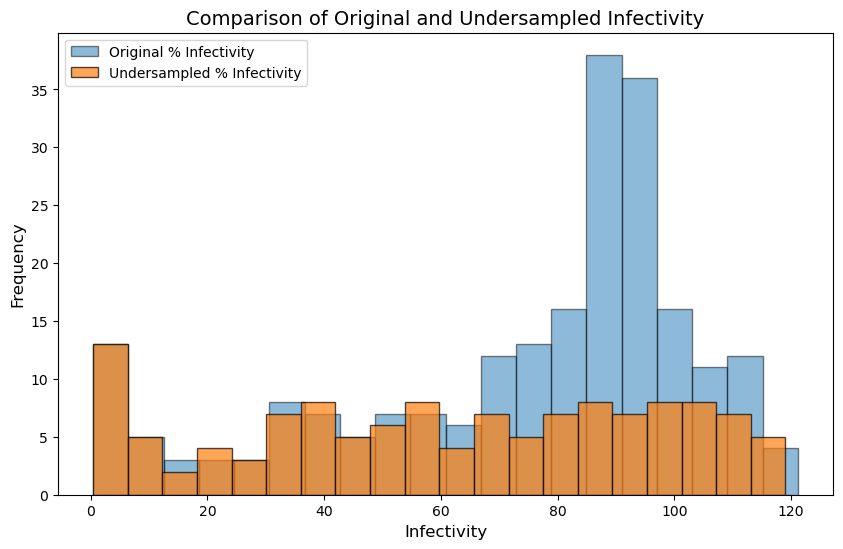

In [ ]:
# Plot the histogram of the original data and the undersampled data together for visual comparison. Should have similar distribution
# across the range.
plt.figure(figsize=(10, 6))
plt.hist(polym_df['% Infectivity'], bins=20, alpha=0.5, label='Original % Infectivity', edgecolor='black')
plt.hist(undersampled_df['% Infectivity'], bins=20, alpha=0.7, label='Undersampled % Infectivity', edgecolor='black')

# Adding labels and title
plt.title('Comparison of Original and Undersampled Infectivity', fontsize=14)
plt.xlabel('Infectivity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Adding a legend to differentiate the histograms
plt.legend()

# Save the figure
output_fig_1 = os.path.join(output_dir, f"{expt_name}_undersampling.tiff")
plt.savefig(output_fig_1, format='tiff', dpi=600)

# Show the plot
plt.show()


In [ ]:
# Reset polym_df after undersampling, so that you don't need to update code below if you do or don't use undersampling.
polym_df = undersampled_df

## Calculate copolymer descriptors

In [ ]:
"""
Import monomer descriptors calculated in Large Monomer Library Generation
Monomer descriptors which are prepared independently using preferred descriptor library, for example RDKit or Mordred. Descriptors already cleaned in previous worflow.
"""
input_data_2 = os.path.join(input_dir, 'clustered_mon_data_MFP.xlsx')  # you need to update with correct filename and extension
monomers_clean = pd.read_excel(input_data_2)

# Remove uncessary columns for model training or monomer definition.
monomers_clean = monomers_clean.drop(columns=['CAS'])
monomers_clean = monomers_clean.drop(columns=['Cluster']) # Don't need clusters until AL section below, but we reload data then.

# Strip leading/trailing spaces from the 'Monomer' column
monomers_clean['Monomer'] = monomers_clean['Monomer'].str.strip()

# Coerce all descriptor columns to numeric (ignores 'Monomer' column)
descriptor_cols = monomers_clean.columns.difference(['Monomer'])
monomers_clean[descriptor_cols] = monomers_clean[descriptor_cols].apply(pd.to_numeric, errors='coerce')

monomers_clean.tail()

,My classification,Monomer,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nBridgehead,nHetero,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
114,Reactive Side Chains,2-Isocyanatoethyl Methacrylate,0,0,0,0,22,11,0,4,...,0.0,8.237744,38.758822,157.073893,7.139722,194,10,42,42,2.777778
115,Polar,Triethylene glycol methyl ether methacrylate,0,0,0,0,38,16,0,5,...,0.0,8.525360,45.487141,234.146724,6.161756,634,15,62,62,4.027778
116,Ionic,2-(Diisopropylamino)ethyl methacrylate,0,1,0,0,40,15,0,3,...,0.0,9.015420,45.524022,215.188529,5.379713,422,18,64,68,3.500000
117,Ionic,2-Methacryloyloxyethyl phosphorylcholine,1,1,0,0,43,19,0,8,...,0.0,9.355047,51.088812,297.134124,6.910096,894,20,86,88,4.152778
118,Polar,n-Hydroxypropyl Methacrylate,0,0,0,0,24,10,0,3,...,0.0,8.168770,37.326413,146.094294,6.087262,143,9,38,38,2.527778


In [ ]:
"""
Calculate copolymer descriptors by performing dot product of monomer descriptors by molar composition of copolymers in the first DataFrame.
Treating copolymer features as the linear combiantion of the indivudal monomer components, without considering other polymer parameters, eg. MW, D(M).
Reference example of copolymer descriptor calculation: https://doi.org/10.1016/j.theochem.2006.04.018
"""
# Initialize an empty result DataFrame
result = pd.DataFrame()

# Set the monomers_clean index to 'Monomer' for easy access
monomers_indexed = monomers_clean.set_index('Monomer')

# Select only the descriptor columns for dot product calculation 
descriptor_columns = monomers_indexed.columns[:]  # Assuming the first column is 'Monomer'

# Iterate over each row (polymer) in polym_df
for index, polymer_row in polym_df.iterrows():
    # Select only the monomer columns defined in mono_head for the current polymer row
    selected_monomers = polymer_row[mono_head]

    # Get the corresponding descriptors for the selected monomers
    # This will only keep the descriptors of the monomers that are actually used in the polymer
    descriptors = monomers_indexed.loc[selected_monomers.index, descriptor_columns]

    # Ensure that the selected_monomers and descriptors are aligned
    # Perform the dot product, which will multiply proportions by descriptors
    polymer_descriptor = selected_monomers.dot(descriptors)

    # Convert the polymer_descriptor Series to DataFrame before concatenation
    polymer_descriptor_df = polymer_descriptor.to_frame().T  # Transpose to have it in the correct shape

    # Concatenate the result to the result DataFrame
    result = pd.concat([result, polymer_descriptor_df], ignore_index=True)

# Combine result_df with polym_df along the columns
polym_desc_df = pd.concat([polym_df.reset_index(drop=True), result.reset_index(drop=True)], axis=1)

# Display the resulting DataFrame
polym_desc_df.head()


,Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4),Triethylene glycol methyl ether methacrylate,Dodecyl Methacrylate,Benzyl Methacrylate,2-(Dimethylamino)ethyl Methacrylate,2-(Diethylamino)ethyl Methacrylate,2-(Diisopropylamino)ethyl Methacrylate,3-Sulfopropyl Methacrylate,3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propane-1-sulfonate,2-Methacryloyloxyethyl phosphorylcholine,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,0.000000,38.559593,0.000000,33.886167,0.0,0.000000,27.55424,0.000000,0.0,0.000000,...,0.0,877.963162,4464.582051,20993.064065,609.351128,45562.797981,1548.776553,6119.563812,6365.32544,354.349095
1,39.000000,0.000000,9.000000,0.000000,0.0,51.000000,0.00000,0.000000,0.0,0.000000,...,0.0,854.249709,4503.087515,22699.92535,567.942298,65631.0,1569.0,6168.0,6270.0,394.25
2,26.639950,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,54.146239,0.0,19.213811,...,0.0,887.483395,4663.222202,26548.513239,794.814798,70390173020.604706,1513.550189,6655.933436,6694.361059,364.244948
3,0.000000,9.590687,0.000000,0.000000,0.0,36.074565,0.00000,54.334748,0.0,0.000000,...,0.0,870.653702,4332.532368,22472.917198,756.771426,70635205618.171829,1300.921191,5513.245857,5585.394988,314.595262
4,45.754106,0.000000,9.262048,0.000000,0.0,45.891422,0.00000,0.000000,0.0,0.000000,...,0.0,871.08741,4633.415766,23689.774854,582.915764,71656.360408,1623.508636,6420.501163,6512.284008,410.96133


In [12]:
#Clean up polymer descriptors to remove descriptors that have not been calculated to a numerical value, are all blank, or all the same.

# Step 1: Remove columns where all values are 0
polym_desc_df = polym_desc_df.loc[:, (polym_desc_df != 0).any(axis=0)]

# Step 2: Remove columns with any missing values
polym_desc_df = polym_desc_df.dropna(axis=1)

# Step 3: Remove columns where all values are the same
polym_desc_df = polym_desc_df.loc[:, (polym_desc_df.nunique() > 1)]

# Save the new dataframe as an excel file, in case this is needed for future reference.
polym_desc_df.to_excel(f'{expt_name}_{desc_pkg}_copolymer descriptors.xlsx', index=None)

# Display the cleaned DataFrame info and head to check if columns were correctly removed
print("\nCleaned DataFrame Info:")
polym_desc_df.info()
print("\nCleaned DataFrame Head:")
polym_desc_df.head()



Cleaned DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Columns: 688 entries, Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4) to mZagreb2
dtypes: float64(12), object(676)
memory usage: 682.8+ KB

Cleaned DataFrame Head:


,Polyethylene Glycol Monomethyl Ether Methacrylate (n=approx. 4),Triethylene glycol methyl ether methacrylate,Dodecyl Methacrylate,Benzyl Methacrylate,2-(Dimethylamino)ethyl Methacrylate,2-(Diethylamino)ethyl Methacrylate,2-(Diisopropylamino)ethyl Methacrylate,3-Sulfopropyl Methacrylate,3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propane-1-sulfonate,2-Methacryloyloxyethyl phosphorylcholine,...,SRW08,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,0.000000,38.559593,0.000000,33.886167,0.0,0.000000,27.55424,0.000000,0.0,0.000000,...,732.648617,877.963162,4464.582051,20993.064065,609.351128,45562.797981,1548.776553,6119.563812,6365.32544,354.349095
1,39.000000,0.000000,9.000000,0.000000,0.0,51.000000,0.00000,0.000000,0.0,0.000000,...,715.490633,854.249709,4503.087515,22699.92535,567.942298,65631.0,1569.0,6168.0,6270.0,394.25
2,26.639950,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,54.146239,0.0,19.213811,...,742.663342,887.483395,4663.222202,26548.513239,794.814798,70390173020.604706,1513.550189,6655.933436,6694.361059,364.244948
3,0.000000,9.590687,0.000000,0.000000,0.0,36.074565,0.00000,54.334748,0.0,0.000000,...,725.64856,870.653702,4332.532368,22472.917198,756.771426,70635205618.171829,1300.921191,5513.245857,5585.394988,314.595262
4,45.754106,0.000000,9.262048,0.000000,0.0,45.891422,0.00000,0.000000,0.0,0.000000,...,730.151351,871.08741,4633.415766,23689.774854,582.915764,71656.360408,1623.508636,6420.501163,6512.284008,410.96133


In [13]:
# Removes the monomer compositon columns and gives an overview of final dataframe for debugging
polym_desc_df = polym_desc_df.drop(columns=mono_head)
polym_desc_df.info()
polym_desc_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Columns: 678 entries, % Infectivity to mZagreb2
dtypes: float64(2), object(676)
memory usage: 672.8+ KB


,% Infectivity,SD % infectivity,Auto Sample ID,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nHetero,nH,...,SRW08,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,11.455522,2.289222,Polyethylene Glycol Monomethyl Ether Methacryl...,27.55424,203.317002,203.317002,3482.360642,1470.787259,343.233019,2011.573383,...,732.648617,877.963162,4464.582051,20993.064065,609.351128,45562.797981,1548.776553,6119.563812,6365.32544,354.349095
1,8.533268,4.445259,Polyethylene Glycol Monomethyl Ether Methacryl...,51.0,0.0,0.0,3939.0,1566.0,405.0,2373.0,...,715.490633,854.249709,4503.087515,22699.92535,567.942298,65631.0,1569.0,6168.0,6270.0,394.25
2,13.403339,7.994553,Polyethylene Glycol Monomethyl Ether Methacryl...,73.36005,0.0,0.0,3486.940076,1629.268805,692.573862,1857.67127,...,742.663342,887.483395,4663.222202,26548.513239,794.814798,70390173020.604706,1513.550189,6655.933436,6694.361059,364.244948
3,10.845824,2.773292,Polyethylene Glycol Monomethyl Ether Methacryl...,90.409313,0.0,0.0,3058.01951,1383.106808,536.520365,1674.912703,...,725.64856,870.653702,4332.532368,22472.917198,756.771426,70635205618.171829,1300.921191,5513.245857,5585.394988,314.595262
4,5.922835,1.356943,Polyethylene Glycol Monomethyl Ether Methacryl...,45.891422,0.0,0.0,4082.345531,1632.633368,430.722998,2449.712163,...,730.151351,871.08741,4633.415766,23689.774854,582.915764,71656.360408,1623.508636,6420.501163,6512.284008,410.96133


## Feature Reduction

In [14]:
"""
Set up test-train splits. When using RFECV, model training and hyperparameter tuning, need to split data before doing feature selection using the model, 
to prevent data leakage to the model.
"""
# Setup groups to ensure any duplicate compositions are not in train and test, to avoid data leakage
groups = polym_desc_df['Auto Sample ID']

# Define features to train (X) and output to predict (y)
X = polym_desc_df.iloc[:, 3:]  # Dropping the first three columns which should be infectivity, SD infectivity and Auto Sample ID
y = polym_desc_df['% Infectivity']  # Extracting the infectivity column
alpha = polym_desc_df['SD % infectivity']  # Extracting the SD infectivity column

# Setting up GroupShuffleSplit for test and train sets, to prevent data leakage.
gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)  

# Perform the split
train_idx, test_idx = next(gss.split(X, y, groups=groups))

# Subset the data using train and test indices for this fold
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
alpha_train, alpha_test = alpha.iloc[train_idx], alpha.iloc[test_idx]
groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]

# Print the number of rows in train and test sets
print(f"Train set size: {len(train_idx)}, Test set size: {len(test_idx)}")
# print('X: ', X)
# print('X_train: ', X_train)
# X_train.to_csv('X_train_1.csv', index=False)
# print('X_test: ', X_test)
# X_test.to_csv('X_test_1.csv', index=False)
# print('y: ', y)
# print('y_train: ', y_train)
# print('y_test: ', y_test)


Train set size: 102, Test set size: 25


In [ ]:
"""
Using the feature generation approach, there will be many more descriptors than are needed for the model. Need to reduce the number of features to 
simplify and speed up training of the model.
Firstly we conduct simple univariate feature selection, to see how each feature correlates with the output variable (% infectivity) alone. This is a crude
estimation, but we can quickly remove features that have no effect.
We then conduct Recursive Feature Reduction, which looks to see how the model performance scales with a reducing number of features. This is a slow
process, as it compares recursively fits the features to the model, then removes the lowest performing feature, and repeats.
This is why we do univariate feature selection first, to reduce time on this step.
"""

# Use univariate feature selection to reduce the number of features
selector = SelectKBest(score_func=f_regression, k=200)  # Select the top 200 features (tune k based on your data)
X_reduced = selector.fit_transform(X_train, y_train) # Using train split to prevent leakage to model. Likely not a big problem here, but more important for RFECV

# Get the selected feature names
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_train.columns[selected_feature_indices]
print("Selected Features after SelectKBest:", selected_feature_names)

Selected Features after SelectKBest: Index(['nBase', 'nAtom', 'nHeavyAtom', 'nN', 'nO', 'ATS0dv', 'ATS1dv',
       'ATS3dv', 'ATS4dv', 'ATS5dv',
       ...
       'MWC03', 'TMWC10', 'SRW02', 'SRW04', 'TSRW10', 'MW', 'WPol', 'Zagreb1',
       'Zagreb2', 'mZagreb2'],
      dtype='object', length=200)


In [16]:
%%time
#Slower Recursive Feature Elimination with Cross Fold Validation, to find minimum number of features.

# Define the variables from the dataframe using the reduced feature from univariate feature analysis (SelectKBest)
X_reduced = X_train.iloc[:, selected_feature_indices]  #Selecting only the reduced features from univariate feature selection above

# Create an instance of GroupKFold with the desired number of splits. Prevents leakage between folds.
gkf = GroupKFold(n_splits=5)

# Initiate model you want to use for RFECV. Currently using RFR as it performs well on antiviral descriptor dataset.
model = RandomForestRegressor(random_state=42)  #It is not necessary to scale data for Random Forest Regressor, so will skip scaling here.

# Create an RFECV instance
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=gkf,  # Use the previously defined GroupKFold
    scoring="r2",
    min_features_to_select=1,
    n_jobs=-1 # n_jobs=-1 uses all available CPU cores
)

# Fit RFECV with the raw data (without scaling) and groups. Only fits to training data set, to prevent leakage of data from test set.
rfecv.fit(X_reduced, y_train, groups=groups_train)

# Get the boolean mask of selected features
selected_features = rfecv.support_

# Get the names of the selected features if you have feature names available
selected_feature_names = X_reduced.columns[selected_features]
print(f"Optimal number of features: {rfecv.n_features_}")
print("Selected Features:", selected_feature_names)


Optimal number of features: 28
Selected Features: Index(['nBase', 'nN', 'AATS3dv', 'AATS2are', 'AATS3are', 'ATSC8m', 'ATSC8i',
       'AATSC3c', 'AATSC2d', 'MATS2se', 'MATS3se', 'MATS3p', 'GATS4se',
       'GATS4pe', 'GATS4are', 'NsssN', 'SsssN', 'MINsCH3', 'nHBAcc', 'IC4',
       'IC5', 'SlogP_VSA3', 'EState_VSA4', 'EState_VSA6', 'JGI2', 'JGI6',
       'JGI8', 'JGI9'],
      dtype='object')
CPU times: total: 1min 44s
Wall time: 3min 52s


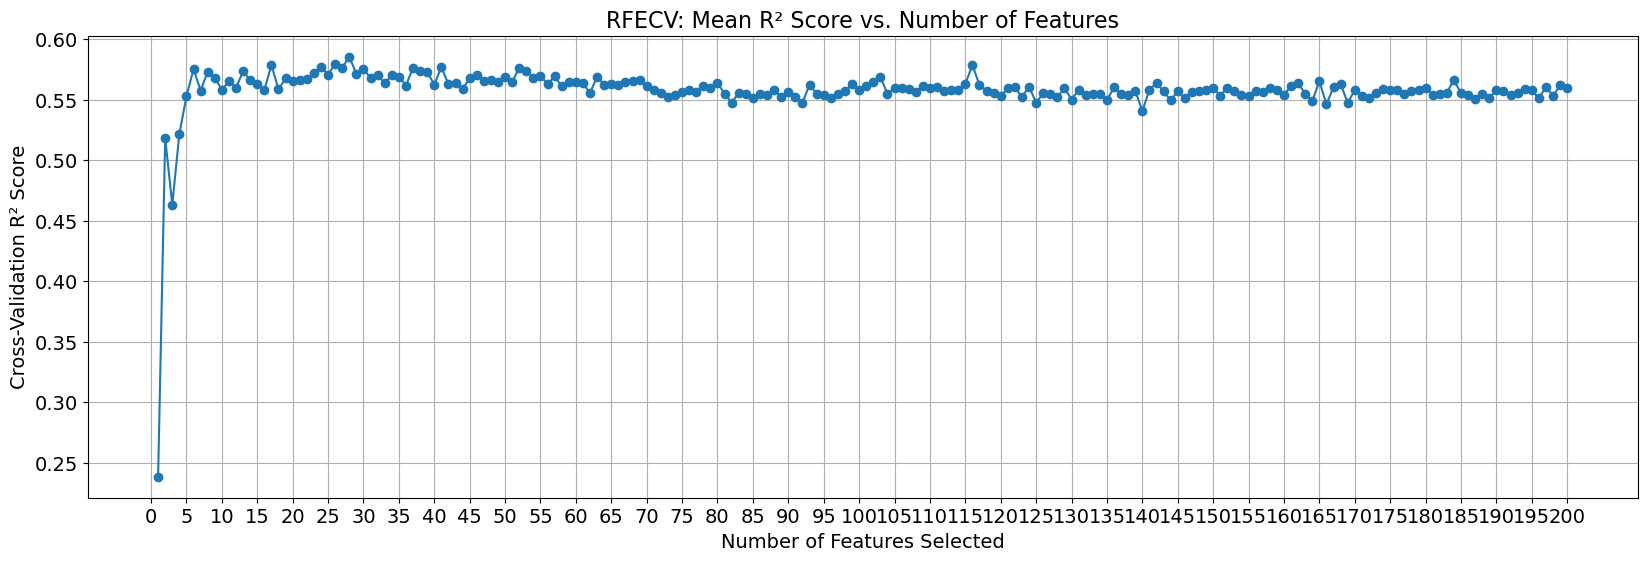

In [ ]:
# Plotting the mean cross-validated score against the number of features
plt.figure(figsize=(20, 6))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
    rfecv.cv_results_['mean_test_score'],
    marker='o'
)
plt.xlabel('Number of Features Selected', fontsize=14)
plt.ylabel('Cross-Validation R² Score', fontsize = 14)
plt.title('RFECV: Mean R² Score vs. Number of Features', fontsize = 16)

plt.tick_params(axis='both', labelsize=14)  # Sets the font size of tick labels
plt.xticks(range(0, len(rfecv.cv_results_['mean_test_score']) + 1, 5))  # X-ticks every 5
plt.grid(True)

# Save the plot as a TIFF file with 300 DPI resolution
output_fig_2 = os.path.join(output_dir, f"{expt_name}_{desc_pkg}_RFECV.tiff") # defines the output filename, using some automated labels from first cell
plt.savefig(output_fig_2, format='tiff', dpi=300)  

plt.show()


In [18]:
"""
You can manually override automated feature selection, and select your own number of highest ranked features. 
This is useful, as the automated process above will find the global maximum, without considering if within error of other values. You want to use
the smallest number of features that explains most of the variability in your dataset.
Using the ranking of features obtained from the RFECV process
"""
feature_ranking = rfecv.ranking_

# Ensure that feature_ranking and X.columns have the same length
print(f"Number of features in X: {len(X_reduced.columns)}")
print(f"Length of feature rankings: {len(feature_ranking)}")

# Select the top XX features based on their rankings. This enusres top XX features are selected, not top XX ranks (which can lead to more than 20 features)
top_n = 17
top_features_indices = np.argsort(feature_ranking)[:top_n]
selected_feature_names = X_reduced.columns[top_features_indices]

print("Top Features Selected:", selected_feature_names)

Number of features in X: 200
Length of feature rankings: 200
Top Features Selected: Index(['nBase', 'AATS3are', 'ATSC8m', 'ATSC8i', 'AATSC3c', 'AATSC2d',
       'MATS2se', 'MATS3se', 'MATS3p', 'GATS4pe', 'GATS4are', 'NsssN', 'SsssN',
       'MINsCH3', 'nHBAcc', 'IC4', 'IC5'],
      dtype='object')


In [ ]:
# Create a new DataFrame with only the selected features from recursive feature selection or manual selection above and save to a csv file.
select_feat_df = polym_desc_df[selected_feature_names]

# Add the target columns '% Infectivity', 'SD % infectivity' and 'Auto Sample ID' to the new DataFrame
select_feat_df.insert(0, '% Infectivity', polym_desc_df['% Infectivity'])
select_feat_df.insert(1, 'SD % infectivity', polym_desc_df['SD % infectivity'])
select_feat_df.insert(2, 'Auto Sample ID', polym_desc_df['Auto Sample ID'])

# Save to file
filename = f'{expt_name}_{desc_pkg}_selected_features.csv'  # you can change filename
output_file_2 = os.path.join(output_dir, filename)
select_feat_df.to_csv(output_file_2, index=False)  
print(f'{filename} has been written to CSV')

# Display the information and the first few rows of the updated DataFrame
select_feat_df.info()


20251021_antiviral polym_AL_Mordred_selected_features.csv has been written to CSV
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   % Infectivity     127 non-null    float64
 1   SD % infectivity  127 non-null    float64
 2   Auto Sample ID    127 non-null    object 
 3   nBase             127 non-null    object 
 4   AATS3are          127 non-null    object 
 5   ATSC8m            127 non-null    object 
 6   ATSC8i            127 non-null    object 
 7   AATSC3c           127 non-null    object 
 8   AATSC2d           127 non-null    object 
 9   MATS2se           127 non-null    object 
 10  MATS3se           127 non-null    object 
 11  MATS3p            127 non-null    object 
 12  GATS4pe           127 non-null    object 
 13  GATS4are          127 non-null    object 
 14  NsssN             127 non-null    object 
 15  SsssN    

## Machine learning on selected copolymer chemical features

In [ ]:
"""
Load in selected features as a csv, so that you don't have to keep repeating feature selection when reloading your kernel. 
Automatically uses filename created above, or can manually change to another file if desired. 
Creates a list of selected feature names needed later for feature importance and SHAP analysis.
"""
# select_feat_df = pd.read_csv(filename)  # Uses automatically defined filename from above.
# filename = '20251013_antiviral polym_AL_Mordred_selected_features.csv' # Manually define filename, if you already have a reduced feature dataset, and want to skip first few steps. If you comment out, then uses filename variable from above.
input_data_3 = os.path.join(output_dir, filename)
select_feat_df = pd.read_csv(input_data_3) 

# Create the list of selected features, excluding the first three columns
selected_feature_names = list(select_feat_df.columns[3:])
groups = select_feat_df['Auto Sample ID']

X = select_feat_df.iloc[:, 3:]  # Dropping the first three columns which should be infectivity, SD infectivity and Auto Sample ID
y = select_feat_df['% Infectivity']
alpha = select_feat_df['SD % infectivity'] 

gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)  
train_idx, test_idx = next(gss.split(X, y, groups=groups))

# Reset X_train and X_test to only include the selected features
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
X_train = X_train[selected_feature_names]
X_test = X_test[selected_feature_names]
alpha_train, alpha_test = alpha.iloc[train_idx], alpha.iloc[test_idx]
groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]
print('Selected features are: ', selected_feature_names)
select_feat_df.info()



Selected features are:  ['nBase', 'AATS3are', 'ATSC8m', 'ATSC8i', 'AATSC3c', 'AATSC2d', 'MATS2se', 'MATS3se', 'MATS3p', 'GATS4pe', 'GATS4are', 'NsssN', 'SsssN', 'MINsCH3', 'nHBAcc', 'IC4', 'IC5']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   % Infectivity     127 non-null    float64
 1   SD % infectivity  127 non-null    float64
 2   Auto Sample ID    127 non-null    object 
 3   nBase             127 non-null    float64
 4   AATS3are          127 non-null    float64
 5   ATSC8m            127 non-null    float64
 6   ATSC8i            127 non-null    float64
 7   AATSC3c           127 non-null    float64
 8   AATSC2d           127 non-null    float64
 9   MATS2se           127 non-null    float64
 10  MATS3se           127 non-null    float64
 11  MATS3p            127 non-null    float64
 12  GATS4pe           127 non-null    fl

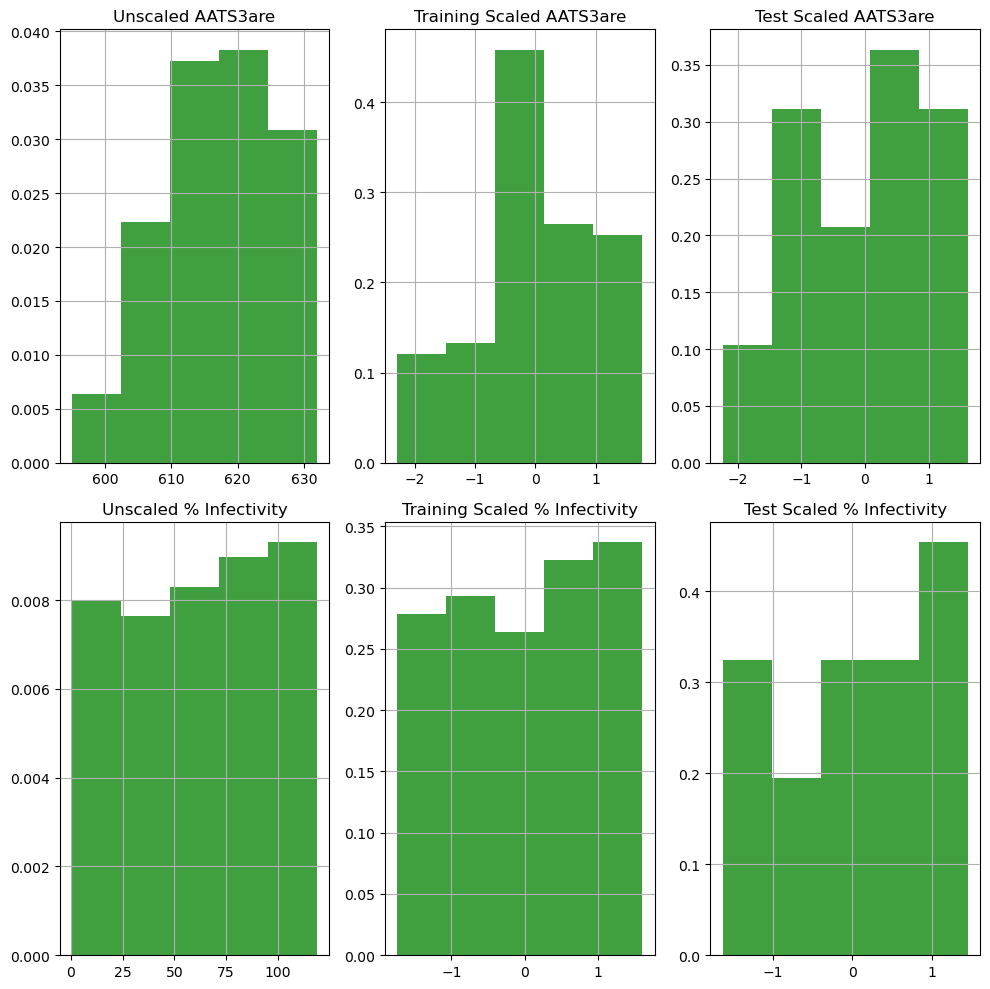

In [21]:
"""
Define X, y and alpha (Standard deviation) variables for the dataset, then scale each of these. The scaling is used in model development on existing
data, but the same scaler has to be applied to predicted data. So you need to run this cell if performing the active learning section below.
Data is scaled to reduce effect of different monomers having higher value ranges for compositions, or different features having wider ranges.
This is more or less important for different models. Should check effect of scaling on different models.
Will generate a couple of plots for quick validation that scaling has been performed correctly.
"""

# Define scalers for each variable
X_scaler = StandardScaler()
y_scaler = StandardScaler()
alpha_scaler = StandardScaler()

# Scale each variable
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.fit_transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()  # Reshape for scaling and flatten back
y_test_scaled = y_scaler.fit_transform(y_test.values.reshape(-1, 1)).flatten()  # Reshape for scaling and flatten back
alpha_train_scaled = alpha_scaler.fit_transform(alpha_train.values.reshape(-1, 1)).flatten()
alpha_test_scaled = alpha_scaler.fit_transform(alpha_test.values.reshape(-1, 1)).flatten()

# Create the new DataFrame with specified columns
# Get Auto Sample ID from polym_desc_df (ensure polym_desc_df exists and is defined)
auto_sample_id = select_feat_df['Auto Sample ID'].values  # Ensure you get it from the correct DataFrame

# Combine scaled values into new DataFrames
transformed_train = pd.DataFrame(X_train_scaled)  # Start with X scaled values
transformed_train.insert(0, 'SD Infectivity', alpha_train_scaled)  # Insert alpha in column 1
transformed_train.insert(0, 'Infectivity', y_train_scaled)  # Insert y in column 0
transformed_train.insert(2, 'Auto Sample ID', groups_train.values)  # Insert Auto Sample ID in column 2

transformed_test = pd.DataFrame(X_test_scaled)  # Start with X scaled values
transformed_test.insert(0, 'SD Infectivity', alpha_test_scaled)  # Insert alpha in column 1
transformed_test.insert(0, 'Infectivity', y_test_scaled)  # Insert y in column 0
transformed_test.insert(2, 'Auto Sample ID', groups_test.values)  # Insert Auto Sample ID in column 2

#Visualisation to check scaling of monomers and infectivity
# Visualization: Create a 3x2 grid for the histograms
fig, axs = plt.subplots(2, 3, figsize=(10, 10))  # Adjust the figure size as needed

# Unscaled Descriptor Histogram (axs[X, y] defines which graph to plot onto the grid.
axs[0, 0].hist(select_feat_df.iloc[:, 4], bins=5, density=True, facecolor='g', alpha=0.75)
axs[0, 0].grid(True)
axs[0, 0].set_title('Unscaled ' + select_feat_df.iloc[:, 4].name)

# Scaled Descriptor Histogram
axs[0, 1].hist(transformed_train.iloc[:, 4], bins=5, density=True, facecolor='g', alpha=0.75)
axs[0, 1].grid(True)
axs[0, 1].set_title('Training Scaled ' + select_feat_df.iloc[:, 4].name)

# Scaled Descriptor Histogram
axs[0, 2].hist(transformed_test.iloc[:, 4], bins=5, density=True, facecolor='g', alpha=0.75)
axs[0, 2].grid(True)
axs[0, 2].set_title('Test Scaled ' + select_feat_df.iloc[:, 4].name)

# Unscaled Infectivity Histogram
axs[1, 0].hist(select_feat_df.iloc[:, 0], bins=5, density=True, facecolor='g', alpha=0.75)
axs[1, 0].grid(True)
axs[1, 0].set_title('Unscaled ' + select_feat_df.iloc[:, 0].name)

# Scaled Infectivity Histogram
axs[1, 1].hist(transformed_train.iloc[:, 0], bins=5, density=True, facecolor='g', alpha=0.75)
axs[1, 1].grid(True)
axs[1, 1].set_title('Training Scaled ' + select_feat_df.iloc[:, 0].name)

# Scaled Infectivity Histogram
axs[1, 2].hist(transformed_test.iloc[:, 0], bins=5, density=True, facecolor='g', alpha=0.75)
axs[1, 2].grid(True)
axs[1, 2].set_title('Test Scaled ' + select_feat_df.iloc[:, 0].name)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [22]:
"""
Initialize models from scikitlearn and define them in a dictionary, to make them easier to call and use later
"""
models_dict = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'Random Forest Regression': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(loss='squared_error', random_state=42), #need to define loss=squared error so IBUG wrapper works later in EI function
    'Stochastic Gradient Regression': SGDRegressor(),
    'K Neighbors Regression': KNeighborsRegressor(),
    'Elastic Net Regression': ElasticNet(random_state=42),
    'Adaptive Boosted Tree Regression': AdaBoostRegressor(random_state=42),
    'Support Vector Regression': SVR(),    
    'Gaussian Process Regression': GaussianProcessRegressor(kernel=C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
        random_state=42, n_restarts_optimizer=10),
}

In [23]:
%%time
"""
Trains and tests a range of standard models from scikit.learn, so you can see how different models perform on the dataset.
These mdoels are not optimised. That is achieved by tuning hyperparameters for each independent model. This is a slow process, so this quick fit
lets you determine what models are worth training.
"""

# Setup groups to prevent duplicates in different folds, which will lead to data leakage.
groups = transformed_train['Auto Sample ID']

# Setting up GroupKFold for cross-validation -- 5 folds
gkf = GroupKFold(n_splits=5)  # We are using grouped K fold to avoid data leakage between folds

# Store model performance and predictions
model_performance = {name: {'R2': [], 'MSE': [], 'Fold R2': [], 'Predictions': []} for name in models_dict}

# Cross-validation loop
for train_idx, val_idx in gkf.split(X_train_scaled, y_train_scaled, groups=groups):
    # Splitting the data
    X_train_kf, X_val_kf = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_kf, y_val_kf = y_train_scaled[train_idx], y_train_scaled[val_idx]
    alpha_train_kf, alpha_val_kf = alpha_train_scaled[train_idx], y_train_scaled[val_idx]

    for name, model in models_dict.items():
        # Train the model
        model.fit(X_train_kf, y_train_kf)
        # Make predictions
        y_pred = model.predict(X_val_kf)
        # Calculate performance metrics
        r2 = r2_score(y_val_kf, y_pred)
        mse = mean_squared_error(y_val_kf, y_pred)
        
        # Store performance metrics
        model_performance[name]['R2'].append(r2)
        model_performance[name]['MSE'].append(mse)
        model_performance[name]['Fold R2'].append(r2) # Store R2 for this fold
        model_performance[name]['Predictions'].append((y_val_kf, y_pred)) # store predicted values for plotting in next cell

# Calculate the average R2 and MSE for each model
for name in models_dict:
    avg_r2 = np.mean(model_performance[name]['R2'])
    avg_mse = np.mean(model_performance[name]['MSE'])
    model_performance[name] = {
        'Avg R2': avg_r2,
        'Avg MSE': avg_mse,
        'Fold R2': model_performance[name]['Fold R2']  # Keep Fold R2 for each fold
    }

# Convert the performance metrics into a DataFrame
model_performance_df = pd.DataFrame(model_performance).T

# If you want to expand Fold R2 into separate columns for each fold
fold_columns = {f'Fold R2 {i+1}': [] for i in range(gkf.n_splits)}
for name in models_dict:
    for i in range(gkf.n_splits):
        fold_columns[f'Fold R2 {i+1}'].append(model_performance[name]['Fold R2'][i])

# Create a DataFrame for fold R2 values
fold_r2_df = pd.DataFrame(fold_columns, index=model_performance_df.index)

# Concatenate the average metrics with fold metrics
final_performance_df = pd.concat([model_performance_df[['Avg R2', 'Avg MSE']], fold_r2_df], axis=1)

# Sort by Avg R2
sorted_final_performance_df = final_performance_df.sort_values(by='Avg R2', ascending=False)
sorted_final_performance_df



C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproce

CPU times: total: 15.4 s
Wall time: 8.72 s


C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


,Avg R2,Avg MSE,Fold R2 1,Fold R2 2,Fold R2 3,Fold R2 4,Fold R2 5
Support Vector Regression,0.653816,0.326306,0.471005,0.699543,0.733811,0.530164,0.834556
Random Forest Regression,0.602243,0.365841,0.493483,0.673372,0.551010,0.538873,0.754479
Gradient Boosting Regression,0.561329,0.393401,0.488853,0.698939,0.372177,0.547598,0.699076
K Neighbors Regression,0.55246,0.419893,0.356901,0.602674,0.474735,0.605038,0.722952
Adaptive Boosted Tree Regression,0.52559,0.434127,0.419672,0.631801,0.393847,0.516951,0.665680
Ridge Regression,0.488186,0.464229,0.354324,0.669801,0.422202,0.334485,0.660118
Stochastic Gradient Regression,0.477586,0.478475,0.285933,0.646086,0.384438,0.409238,0.662234
Linear Regression,0.446754,0.51835,0.210799,0.578723,0.520178,0.286136,0.637934
Decision Tree Regression,0.364022,0.554242,0.684372,0.366064,0.006702,0.243421,0.519554
Elastic Net Regression,0.137592,0.812103,0.063092,0.190993,0.007734,0.243098,0.183043


C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproce

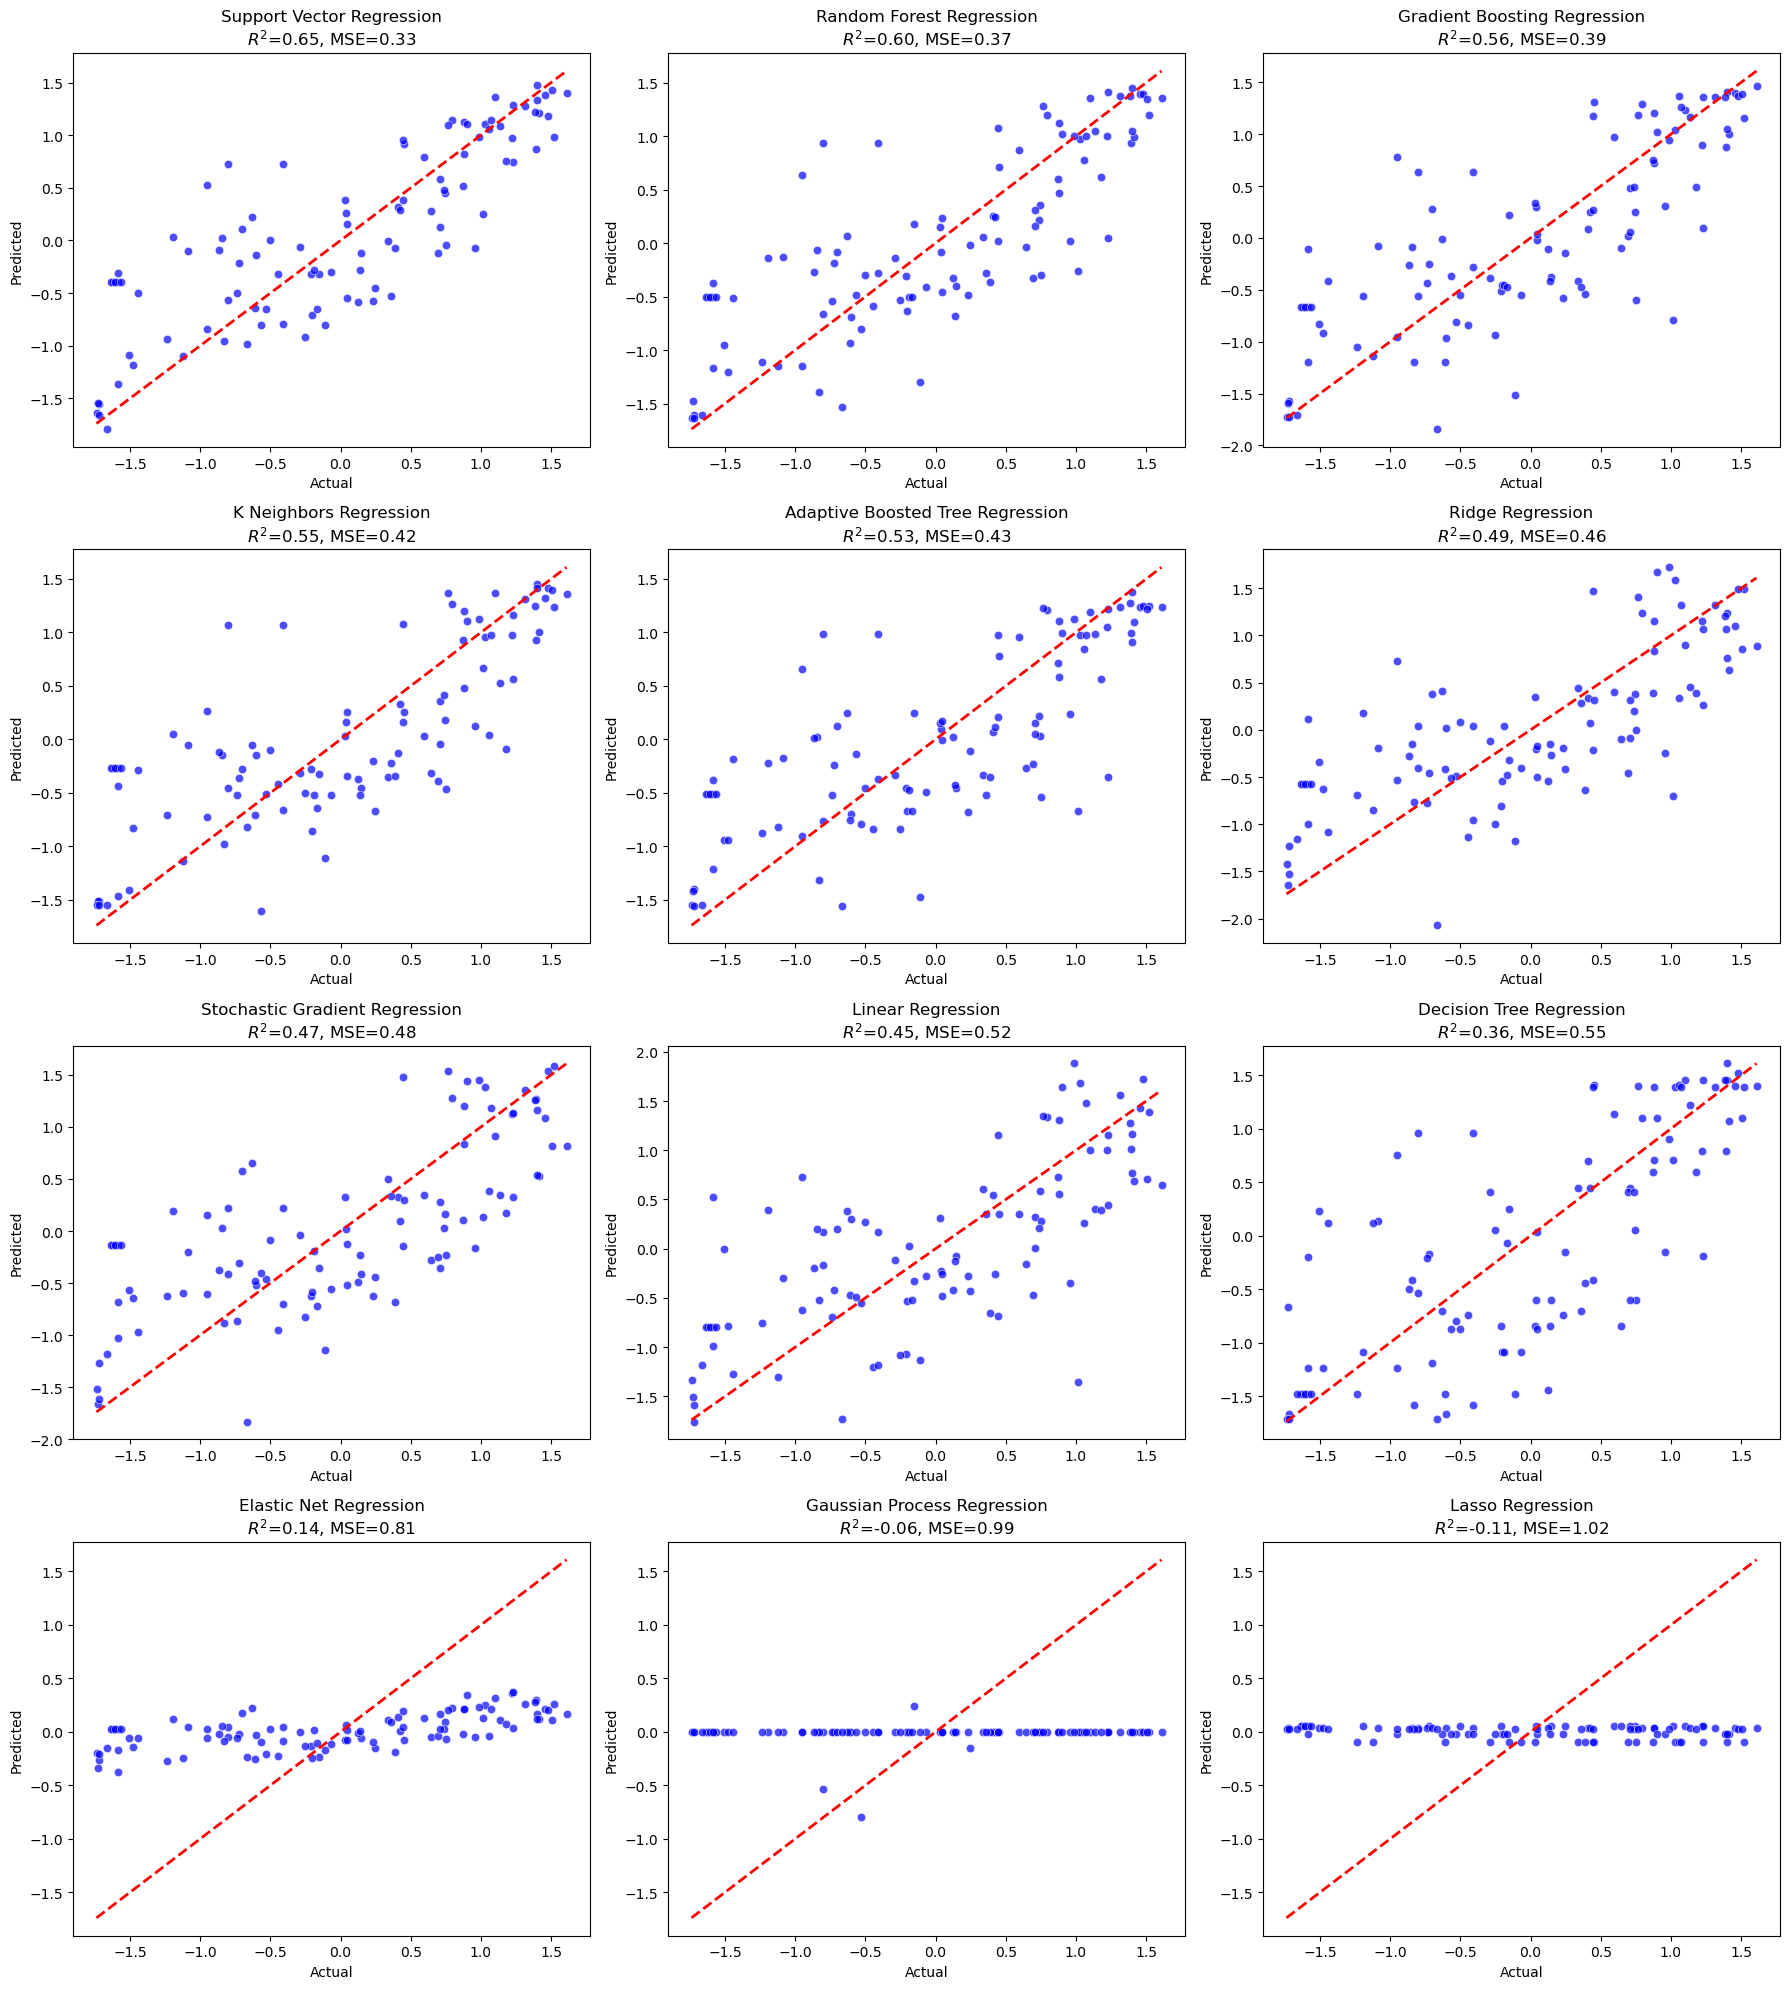

In [ ]:
"""
Plotting each ML model to show differences in correlation between real and predicted values
"""
# Setup groups for GroupKFold
groups = transformed_train['Auto Sample ID']
gkf = GroupKFold(n_splits=5)

# Store performance
model_performance = {name: {'R2': [], 'MSE': [], 'Predictions': []} for name in models_dict}

# Train, predict, store metrics
for train_idx, val_idx in gkf.split(X_train_scaled, y_train_scaled, groups=groups):
    X_train_kf, X_val_kf = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_kf, y_val_kf = y_train_scaled[train_idx], y_train_scaled[val_idx]
    
    for name, model in models_dict.items():
        model.fit(X_train_kf, y_train_kf)
        y_pred = model.predict(X_val_kf)
        
        r2 = r2_score(y_val_kf, y_pred)
        mse = mean_squared_error(y_val_kf, y_pred)

        model_performance[name]['R2'].append(r2)
        model_performance[name]['MSE'].append(mse)
        model_performance[name]['Predictions'].append((y_val_kf, y_pred))

# Average metrics and sort by R2
avg_metrics = {name: {'Avg R2': np.mean(data['R2']), 'Avg MSE': np.mean(data['MSE'])} 
               for name, data in model_performance.items()}
avg_metrics_df = pd.DataFrame(avg_metrics).T.sort_values('Avg R2', ascending=False)

# Plotting
n_cols = 3
n_models = len(models_dict)
n_rows = int(np.ceil(n_models / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

for idx, name in enumerate(avg_metrics_df.index):
    ax = axes[idx]
    
    # Combine all folds for scatter plot
    y_true_all = np.concatenate([t[0] for t in model_performance[name]['Predictions']])
    y_pred_all = np.concatenate([t[1] for t in model_performance[name]['Predictions']])
    
    # Scatter plot
    sns.scatterplot(x=y_true_all, y=y_pred_all, ax=ax, color='blue', alpha=0.7)
    ax.plot([y_true_all.min(), y_true_all.max()], 
            [y_true_all.min(), y_true_all.max()], 'r--', linewidth=2)
    
    # Titles
    ax.set_title(f"{name}\n$R^2$={avg_metrics_df.loc[name,'Avg R2']:.2f}, "
                 f"MSE={avg_metrics_df.loc[name,'Avg MSE']:.2f}", fontsize=12)
    ax.set_xlabel("Actual", fontsize=10)
    ax.set_ylabel("Predicted", fontsize=10)

# Remove empty axes
for i in range(idx+1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
output_fig_3 = os.path.join(output_dir, f'{expt_name}_allMLmodels.png')
plt.savefig(output_fig_3, format='png', dpi=600)
plt.show()


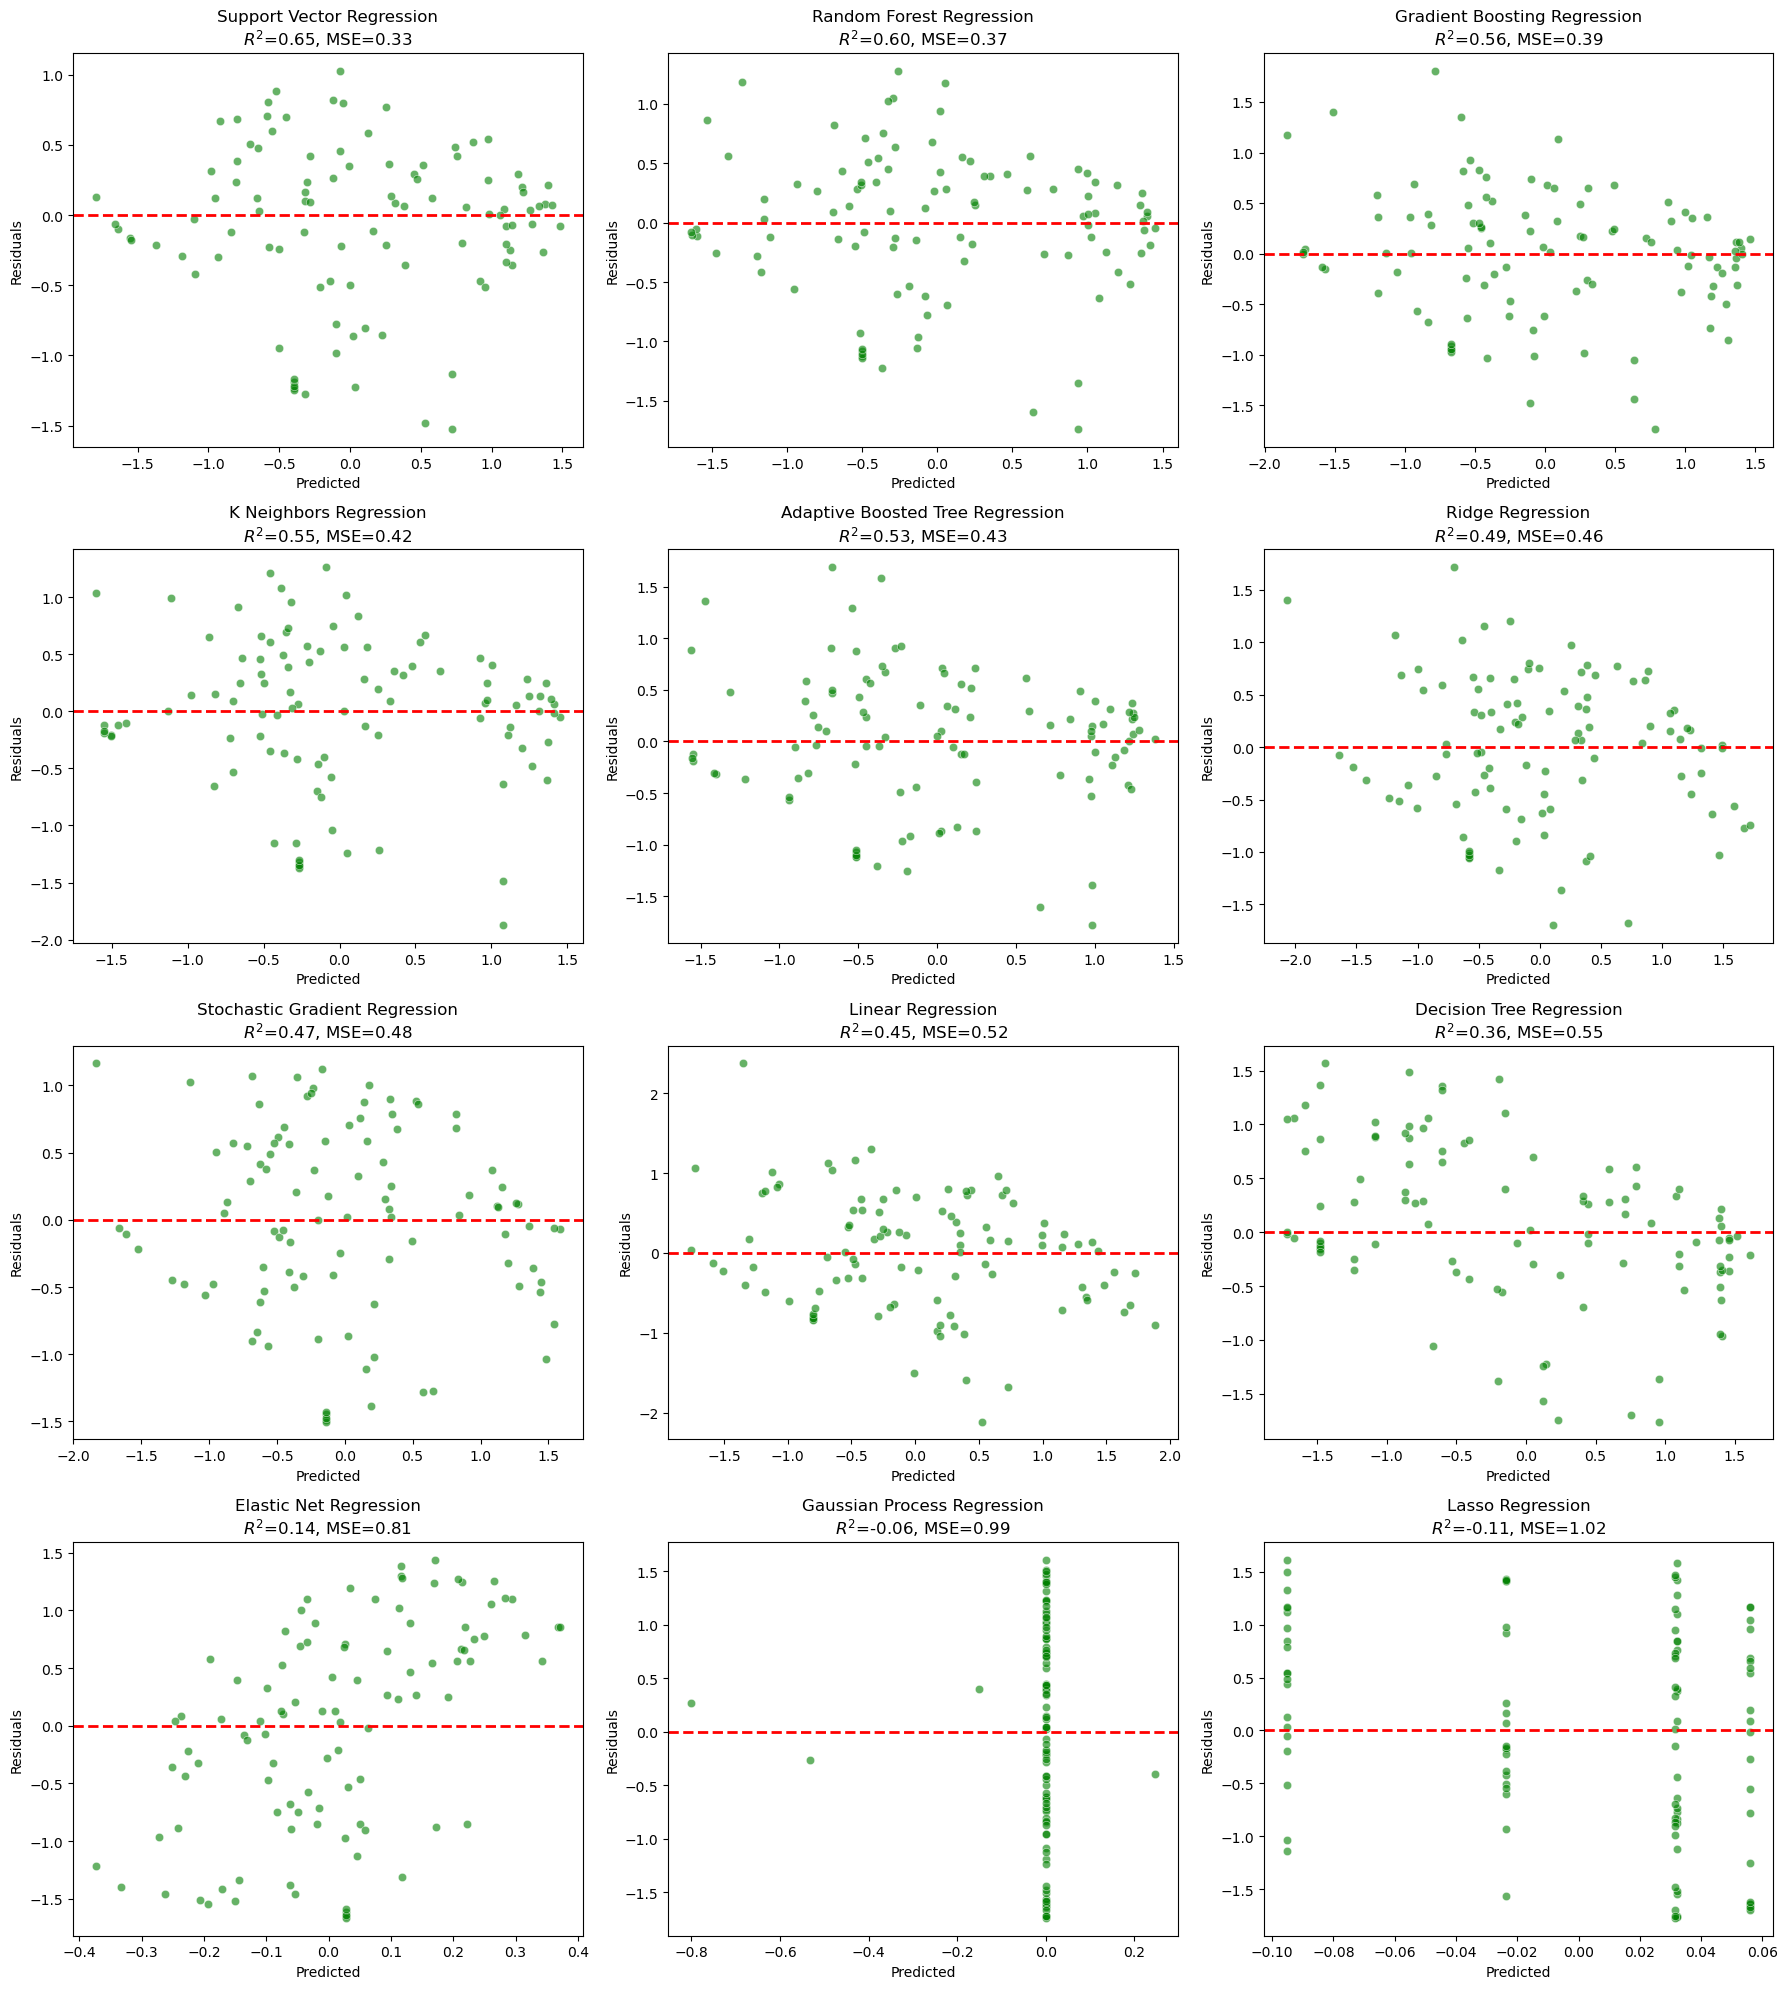

In [ ]:
"""
Plot residuals for each ML model to show differences in prediction errors
(Predicted values on x-axis)
"""
# Setup same as before
n_cols = 3
n_models = len(models_dict)
n_rows = int(np.ceil(n_models / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

for idx, name in enumerate(avg_metrics_df.index):
    ax = axes[idx]
    
    # Combine all folds
    y_true_all = np.concatenate([t[0] for t in model_performance[name]['Predictions']])
    y_pred_all = np.concatenate([t[1] for t in model_performance[name]['Predictions']])
    
    # Compute residuals
    residuals = y_true_all - y_pred_all
    
    # Scatter plot: Residuals vs Predicted
    sns.scatterplot(x=y_pred_all, y=residuals, ax=ax, color='green', alpha=0.6)
    ax.axhline(0, color='red', linestyle='--', linewidth=2)  # zero residual line
    
    # Titles
    ax.set_title(f"{name}\n$R^2$={avg_metrics_df.loc[name,'Avg R2']:.2f}, "
                 f"MSE={avg_metrics_df.loc[name,'Avg MSE']:.2f}", fontsize=12)
    ax.set_xlabel("Predicted", fontsize=10)
    ax.set_ylabel("Residuals", fontsize=10)

# Remove empty axes
for i in range(idx+1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
output_fig_4 = os.path.join(output_dir, f'{expt_name}_allMLmodels_residuals.png')
plt.savefig(output_fig_4, format='png', dpi=600)
plt.show()


In [26]:
%%time
"""
Each model above will have different hyperparameters that will need to be tuned. Need to check what is necessary for each model and update accordingly.
Nested cross-validation. We tune hyperparameters and train the model using each of the 5 folds in the dataset to improve robustness and 
generalizability of the model. Very high performance, but slow.
"""
# Define the model you want to train and tune hyperparamters for. Use name from dictionary to call automatically
model_name = 'Random Forest Regression'
model = models_dict[model_name]

# Create groups based on sample ID, to ensure duplicate compositions don't end up in test and train datasets. Prevents data leakage in the model.
groups = transformed_train['Auto Sample ID']

# GroupKFold for CV on training data
gkf = GroupKFold(n_splits=5)

# Define scoring metrics
scoring = {
    'r2': make_scorer(r2_score),
    'mse': make_scorer(mean_squared_error, greater_is_better=False),  # Negative MSE
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),  # Negative MAE
}

# Set up parameter distributions for hyperparameter tuning
param_distributions = {
    'n_estimators': [int(x) for x in np.linspace(50, 2000, 20)],  # Number of trees in the forest
    'max_features': ['sqrt', 'log2'], # Max features to consider at every split
    'min_samples_split': [2, 3, 5, 10],  # Minimum samples required to split a node
    'max_depth': [5, 10, 20, 30]  # Maximum depth of the tree
}

# Store performance across folds for final summary
outer_cv_scores = []

# Outer cross-validation loop
for train_idx, val_idx in gkf.split(X_train_scaled, y_train_scaled, groups=groups):
    
    # Define inner train and validation sets
    X_outer_train, X_outer_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_outer_train, y_outer_val = y_train_scaled[train_idx], y_train_scaled[val_idx]
    groups_outer_train = groups_train.iloc[train_idx]
    
    # Inner cross-validation for hyperparameter tuning
    model_RS = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=100,
        cv=gkf,  # Inner GroupKFold within outer fold
        random_state=42,
        scoring=scoring,
        refit='r2',
        n_jobs=-1
    )
    
    # Fit the inner RandomizedSearchCV on the current outer training fold
    model_RS.fit(X_outer_train, y_outer_train, groups=groups_outer_train)
    
    # Get the best model from inner CV
    final_model = model_RS.best_estimator_
    
    # Evaluate the best model on the outer validation set
    outer_r2 = r2_score(y_outer_val, final_model.predict(X_outer_val))
    outer_cv_scores.append(outer_r2)
    
    print(f"Outer Fold R2 Score: {outer_r2}")

# Get the best hyperparameters
best_params = model_RS.best_params_
print("Best Hyperparameters:", best_params)

# Final model performance summary
print("Nested CV Mean R2 Score:", np.mean(outer_cv_scores))
print("Nested CV R2 Scores across outer folds:", outer_cv_scores)

Outer Fold R2 Score: 0.5034703719096365
Outer Fold R2 Score: 0.6707410405596794
Outer Fold R2 Score: 0.6316441810438143
Outer Fold R2 Score: 0.6037310546210961
Outer Fold R2 Score: 0.7618508904956305
Best Hyperparameters: {'n_estimators': 2000, 'min_samples_split': 3, 'max_features': 'sqrt', 'max_depth': 10}
Nested CV Mean R2 Score: 0.6342875077259713
Nested CV R2 Scores across outer folds: [0.5034703719096365, 0.6707410405596794, 0.6316441810438143, 0.6037310546210961, 0.7618508904956305]
CPU times: total: 14.6 s
Wall time: 19min 23s


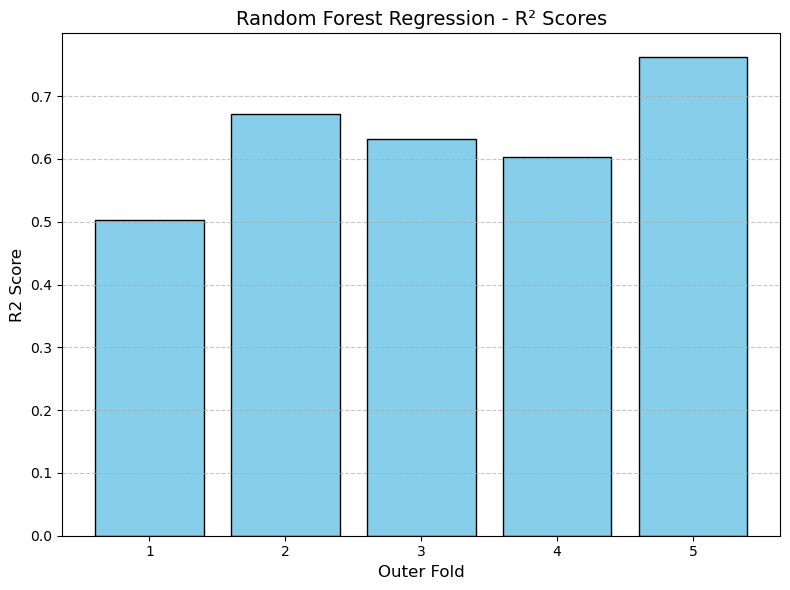

In [ ]:
# Plotting the bar graph for outer_cv_scores
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(outer_cv_scores) + 1), outer_cv_scores, color='skyblue', edgecolor='black')

# Adding labels, title, and grid
plt.xlabel("Outer Fold", fontsize=12)
plt.ylabel("R2 Score", fontsize=12)
plt.title(f"{model_name} - R² Scores", fontsize=14)
plt.xticks(range(1, len(outer_cv_scores) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot to a file
output_fig_5 = os.path.join(output_dir, f"{model_name}_r2_scores_with_border.png")
plt.savefig(output_fig_5, format="png", dpi=300)

# Display the plot
plt.show()


In [ ]:
"""
Use trained model to predict on test set, to test performance of model
"""
# Make sure model is fit on entire training data set
final_model.fit(X_train_scaled, y_train_scaled)

# Predict on test data set and evaluate fit on scaled data
predictions = final_model.predict(X_test_scaled) # Predictions made on the test set
mse_test = mean_squared_error(y_test_scaled, predictions) #Evaluation of MSE based on actual label (y_test) and predicted label
mae_test = mean_absolute_error(y_test_scaled, predictions) #Evaluation of MAE based on actual label (y_test) and predicted label
r2_test = r2_score(y_test_scaled, predictions) #Evaluation of r2 based on actual label (y_test) and predicted label
rmse_test = root_mean_squared_error(y_test_scaled, predictions)
print('MSE on scaled test set: ',mse_test)
print('MAE on scaled test set: ',mae_test)
print('R2 on scaled test set: ',r2_test )
print('RMSE on scaled test set: ',rmse_test)

MSE on scaled test set:  0.2608823017195608
MAE on scaled test set:  0.39819138521398867
R2 on scaled test set:  0.7391176982804393
RMSE on scaled test set:  0.5107663866383151


In [ ]:
# Inverse transform predictions
predictions_unscaled = y_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_test_unscaled = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Compute metrics in original units, in this case % infectivity
mse_test_orig = mean_squared_error(y_test_unscaled, predictions_unscaled)
rmse_test_orig = root_mean_squared_error(y_test_unscaled, predictions_unscaled)
mae_test_orig = mean_absolute_error(y_test_unscaled, predictions_unscaled)
r2_test_orig = r2_score(y_test_unscaled, predictions_unscaled)
rmse_test_orig = root_mean_squared_error(y_test_unscaled, predictions_unscaled)
print('MSE (original units):', mse_test_orig)
print('MAE (original units):', mae_test_orig)
print('R2 (original units):', r2_test_orig)
print('RMSE on scaled test set: ',rmse_test_orig)

MSE (original units): 294.7032364408604
MAE (original units): 13.38326273116195
R2 (original units): 0.7391176982804393
RMSE on scaled test set:  17.166922742322235


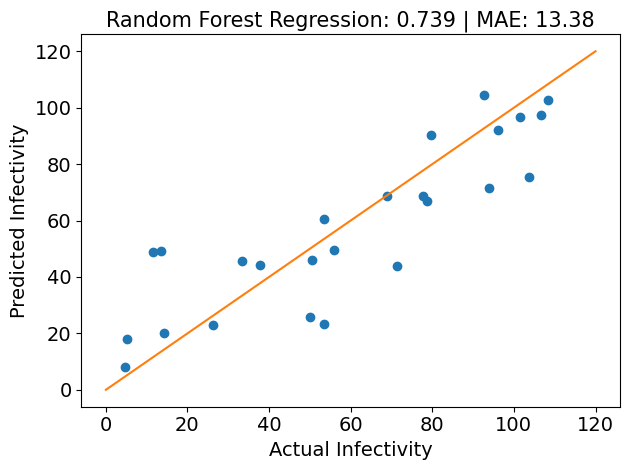

In [ ]:
#Unscale predicted data, and plot against original % infectivity data (y)
predictions_unscaled = y_scaler.inverse_transform(predictions.reshape(-1,1))

plt.plot(y_test, predictions_unscaled, 'o')
plt.title(f'{model_name}: {round(r2_test, 3)} | MAE: {round(mae_test_orig, 2)}', fontsize=15)
plt.xlabel('Actual Infectivity', fontsize = 14)
plt.ylabel('Predicted Infectivity', fontsize = 14)
plt.tick_params(axis='both', labelsize=14)  # Sets the font size of tick labels
plt.plot([0,120],[0,120]) # draws a perfect correlation line for the fit, as a guide for the eye

# Use tight layout to avoid cutting off labels
plt.tight_layout()

# Save the plot as a tiff image at 300 dpi
output_fig_6 = os.path.join(output_dir, f'{expt_name}_{desc_pkg}_{model_name}_test fit.tiff') #defines the filename using some parameters from second cell.
plt.savefig(output_fig_6, format='tiff', dpi=600)  

plt.show()

Number of feature importances: 17


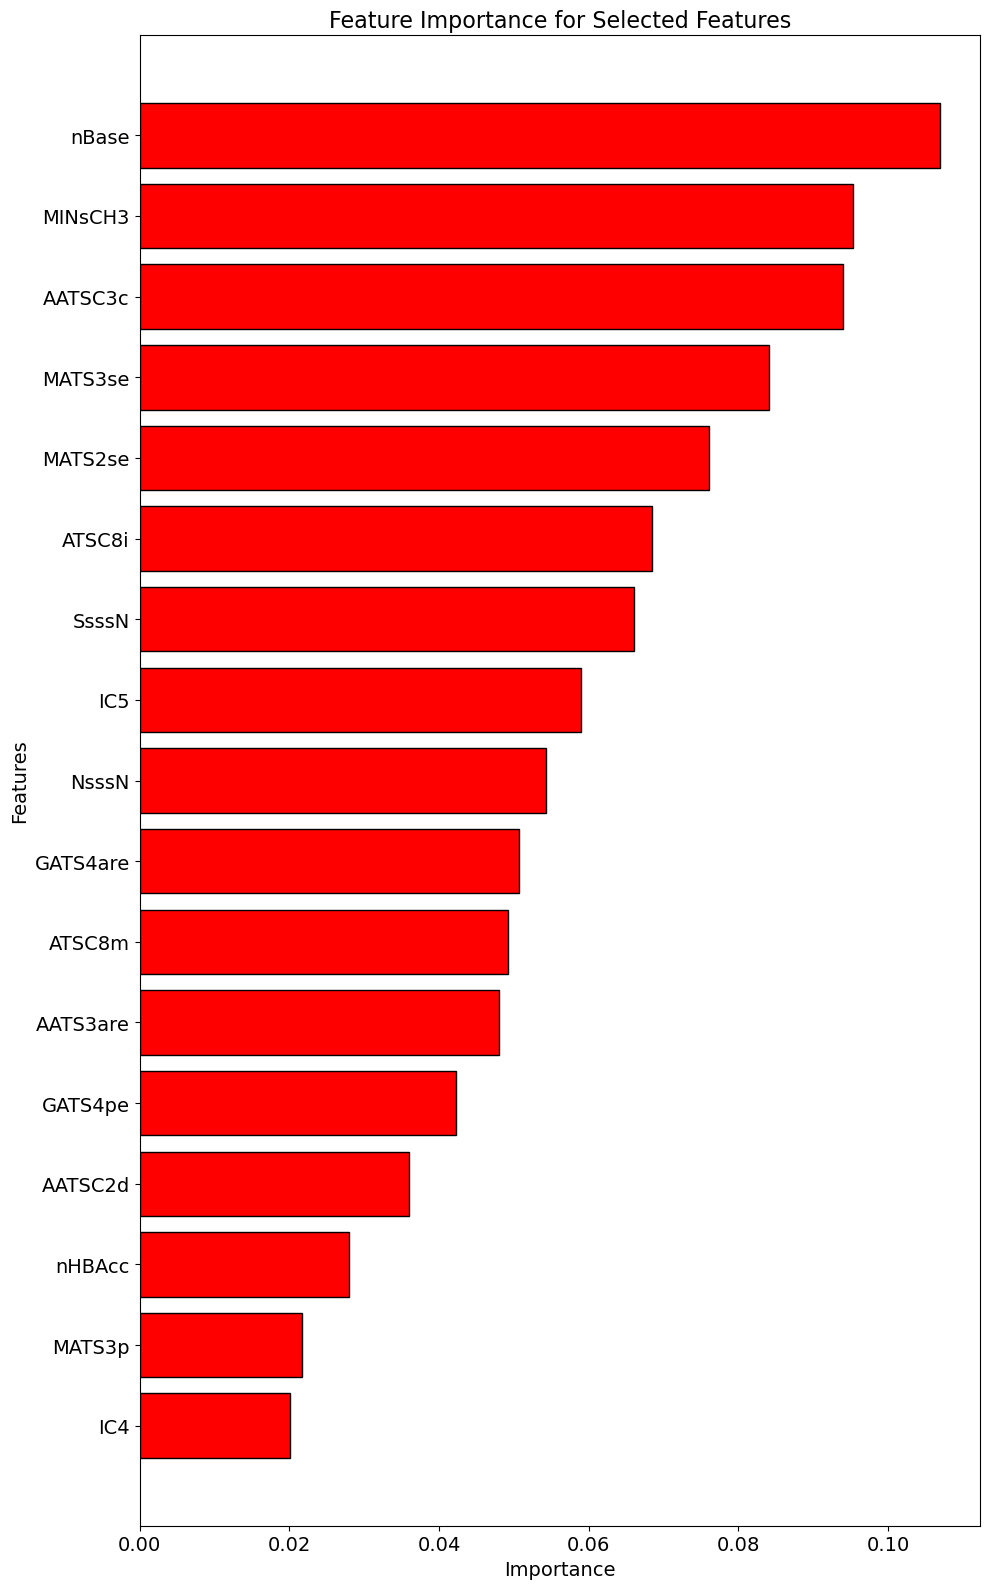

In [ ]:
"""
Histogram plot of feature importance for the model, ranked in order of importance.
"""
# Step 1: Extract Feature Importance
feature_importances = final_model.feature_importances_

# Check the length of feature_importances
print("Number of feature importances:", len(feature_importances))

importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': feature_importances  # Ensure this matches the selected features
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Step 3: Create a Horizontal Bar Plot
plt.figure(figsize=(10, 16))  # Set figure size
plt.barh(importance_df['Feature'], importance_df['Importance'], color='red', edgecolor='black')

# Set title and labels
plt.title('Feature Importance for Selected Features', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Use tight layout to avoid cutting off labels
plt.tight_layout()

# Save the plot as a tiff image at 300 dpi 
output_fig_7 = os.path.join(output_dir, f'{expt_name}_{desc_pkg}_{model_name}_feature_importance.tiff')
plt.savefig(output_fig_7, format='tiff', dpi=600)

# Show the plot
plt.show()
#Set up image

 95%|=================== | 97/102 [00:15<00:00]       

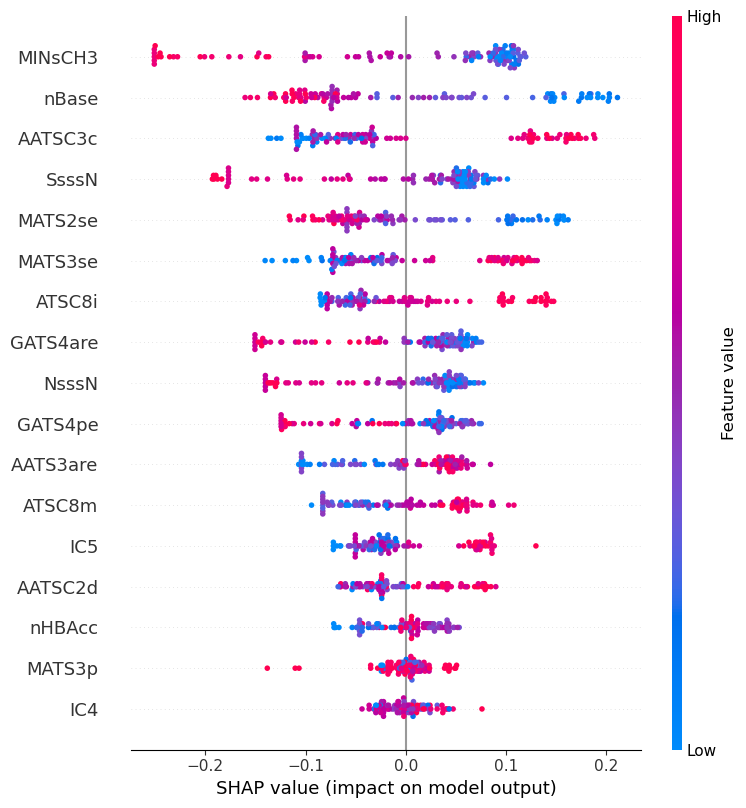

In [ ]:
"""
SHAP beeswarm plot, showing relative impact of each feature, and how it scales with feature.
"""
# Adjust the font sizes for the SHAP plot
plt.rc('font', size=14)              # Set the default text size for all elements
plt.rc('axes', titlesize=16)         # Set the font size of the axes titles
plt.rc('axes', labelsize=14)         # Set the font size of the x and y axis labels
plt.rc('xtick', labelsize=14)        # Set the font size of the tick labels on the x-axis
plt.rc('ytick', labelsize=14)        # Set the font size of the tick labels on the y-axis
plt.rc('legend', fontsize=14)        # Set the font size of the color bar (legend) labels

# Initialize the explainer with the best estimator

# Initialize the explainer with the best estimator
# Use the training data or the data used to calculate feature importances
explainer = shap.Explainer(final_model, X_train_scaled, feature_names=selected_feature_names)

# Calculate SHAP values for the same data used in training/testing
shap_vals = explainer(X_train_scaled)  # Ensure this data has the same shape as expected

# Create a new figure for the SHAP summary plot
plt.figure()

# Generate the SHAP summary plot
shap.summary_plot(shap_vals, show=False, max_display=50)  # Use show=False to prevent it from displaying immediately

# Save the SHAP summary plot as a tiff image at 300 DPI
output_fig_8 = os.path.join(output_dir, f'{expt_name}_{desc_pkg}_{model_name}_SHAP.tiff')
plt.savefig(f'{expt_name}_{desc_pkg}_{model_name}_SHAP.tiff', format='tiff', dpi=600) 

# Display the plot
plt.show()


In [ ]:
# Save trained model to a file, automatically including date, experiment, and model name
output_model = os.path.join(output_dir, f'{expt_name}_{model_name}.joblib')
joblib.dump(final_model, output_model)

print(f"Model saved to: {output_model}")

['20251021_antiviral polym_AL_Random Forest Regression.joblib']

## Prediction to new monomers and copolymers

Preparation of data and new copolymers to test

In [ ]:
## Load model from a saved file, means you can start script from here, without doing training above. Need to update filename to correct model and descriptor list.
best_estimator = joblib.load(output_model) # Automatically defined model from variable above 

## Alternatively, manually define an earlier saved model to load.
# input_model = os.path.join(output_dir, f'20251013_antiviral polym_AL_Random Forest Regression.joblib') # change filename to use different models
# best_estimator = joblib.load(input_model) # Define an earlier saved model. 

print(f"Model loaded from: {output_model}")

In [ ]:
"""
Import monomer descriptors
Monomer descriptors which are prepared independently using preferred descriptor library, for example RDKit or Mordred.
Add a name for the desc_pkg variable to amend file names, to create unique outputs - images, csv, saved models, etc. Will allow you to 
use different predictors/features and compare model performance.
Descriptors have already been cleaned to remove any that did not calculate correctly or give unique features.
"""
desc_pkg = 'Mordred' # define descriptor package you have used. We define this variable again so that you can start from a pre-saved model, rather than running whole workflow again.
input_data_4 = os.path.join(input_dir, f'clustered_mon_data_MFP.xlsx') # need to define filename as output from Large Monomer Library Generation worksflow.
monomers_clean = pd.read_excel(input_data_4)

# Remove uncessary columns for model training or monomer definition.
monomers_clean = monomers_clean.drop(columns=['CAS'])

# Strip leading/trailing spaces from the 'Monomer' column
monomers_clean['Monomer'] = monomers_clean['Monomer'].str.strip()

print(input_data_4)
monomers_clean.head()


,Monomer,Cluster,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nBridgehead,nHetero,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,Methyl Methacrylate,6,0,0,0,0,17,7,0,2,...,0.000000,7.890957,32.688753,102.068080,6.004005,46,6,26,26,1.777778
1,3-Hydroxy-1-methacryloyloxyadamantane,2,0,0,0,0,39,17,4,3,...,0.000000,10.297184,51.266300,238.156895,6.106587,466,27,100,120,3.402778
2,Isobornyl Methacrylate,1,0,0,0,0,40,16,2,2,...,7.984463,10.161419,66.429498,224.177630,5.604441,407,27,90,112,3.298611
3,Butyl Methacrylate,7,0,0,0,0,26,10,0,2,...,0.000000,8.168770,37.326413,144.115030,5.542886,143,9,38,38,2.527778
4,Ethyl Methacrylate,7,0,0,0,0,20,8,0,2,...,0.000000,8.011355,34.323564,116.083730,5.804186,70,7,30,30,2.027778


In [ ]:
"""
Create a dictionary for all monomers in the library, defining ranges for random number generator based on classification.
You don't want to include 0 in the range, as zero for any given monomer is the same as not randomly sampling. Reduces the number of duplicates you create.
This uses monomers clusterd by PCA + k-means clustering analysis to identify monomer classes. 
"""

# Build a dictionary of monomers grouped by cluster
cluster_dict = monomers_clean.groupby('Cluster')['Monomer'].apply(list).to_dict()

# Define the allowed composition range (10 to 50 in increments of 10)
comp_range = np.arange(10, 51, 10).tolist()


In [ ]:
%%time
from collections import defaultdict

# Example: monomers_clean has columns ['Monomer', 'Cluster']
# cluster_dict groups monomers by cluster
cluster_dict = monomers_clean.groupby('Cluster')['Monomer'].apply(list).to_dict()
comp_range = np.arange(10, 51, 10).tolist()  # composition increments

max_combinations = 50000 # define total number of polymers you want to create
max_per_monomer = 2000  # define max number of times any single monomer can be used. Ensures many different monomers are used. Rule of thumb rough 1/10 to 1/20 size of max_combinations.  
combinations = []

# Track usage count per monomer
monomer_count = defaultdict(int)

while len(combinations) < max_combinations:
    # Randomly pick 2-4 clusters
    n_clusters_to_use = random.randint(2, 4)
    chosen_clusters = random.sample(list(cluster_dict.keys()), n_clusters_to_use)
    
    # Pick one monomer from each cluster that hasn't hit max_per_monomer yet
    chosen_monomers = []
    for c in chosen_clusters:
        available_monomers = [m for m in cluster_dict[c] if monomer_count[m] < max_per_monomer]
        if not available_monomers:
            break  # cannot pick from this cluster, skip this iteration
        chosen_monomers.append(random.choice(available_monomers))
    
    if len(chosen_monomers) != n_clusters_to_use:
        continue  # skip if couldn't pick enough monomers
    
    # Assign random composition values (increments of 10)
    values = [random.choice(comp_range) for _ in chosen_monomers]
    
    # Check if sum is 100
    if sum(values) == 100:
        combinations.append(dict(zip(chosen_monomers, values)))
        # Increment usage count for each monomer
        for m in chosen_monomers:
            monomer_count[m] += 1

# Convert to DataFrame
df_combinations = pd.DataFrame(combinations).fillna(0)

print(f"✅ Total valid combinations generated: {len(df_combinations)}")
df_combinations.head()


✅ Total valid combinations generated: 500000
CPU times: total: 1min 1s
Wall time: 1min 2s


,Diethylene Glycol Monomethyl Ether Methacrylate,Methacrylic Anhydride,3-[Dimethoxy(methyl)silyl]propyl Methacrylate,3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propane-1-sulfonate,Methacrylic Acid,"1H,1H,5H-Octafluoropentyl Methacrylate",3-(Triethoxysilyl)propyl Methacrylate,2-Ethoxyethyl Methacrylate,2-Hydroxybutyl Methacrylate,3-[Tris(trimethylsilyloxy)silyl]propyl Methacrylate,...,1-Ethoxyethyl Methacrylate,Triethylene glycol methyl ether methacrylate,3-Chloro-2-hydroxypropyl Methacrylate,Dicyclopentanyl Methacrylate,Allyl Methacrylate,"2-(Methacryloyloxy)-N,N,N-trimethylethanaminium Methyl Sulfate",3-[[2-(Methacryloyloxy)ethyl]dimethylammonio]propionate,"2,2,3,3-Tetrafluoropropyl Methacrylate",5-Oxotetrahydrofuran-3-yl Methacrylate,Tetrahydrofurfuryl Methacrylate
0,50.0,30.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,30.0,30.0,40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,40.0,30.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Remove duplicate compositions that are randomly generated.
print("Original polymer library:", df_combinations.shape)
df_combinations = df_combinations.drop_duplicates()
print("Duplicates removed:", df_combinations.shape)

# Initialize cluster usage dictionary
cluster_usage = defaultdict(int)

# Loop through each monomer that was used
for monomer, count in monomer_count.items():
    # Find which cluster this monomer belongs to
    cluster = monomers_clean.loc[monomers_clean['Monomer'] == monomer, 'Cluster'].values[0]
    cluster_usage[cluster] += count

# Print usage per cluster to check all clusters are used fairly. Good for troubleshooting.
print("Cluster usage (number of times monomers from each cluster were used):")
for cluster, usage in sorted(cluster_usage.items()):
    print(f"Cluster {cluster}: {usage}")

Original polymer library: (500000, 118)
Duplicates removed: (427631, 118)
Cluster usage (number of times monomers from each cluster were used):
Cluster 0: 161813
Cluster 1: 161769
Cluster 2: 162351
Cluster 3: 161927
Cluster 4: 162762
Cluster 5: 161762
Cluster 6: 161796
Cluster 7: 161454
Cluster 8: 161846
Cluster 9: 160000


In [ ]:
%%time
# Set the cluster number you want to inspect to check how many times each monomer in that cluster has been used. For troubleshooting. Warning this can be a little slow ~ 10 mins
cluster_to_check = 9

# Initialize dictionary to hold counts for this cluster
monomer_counts = defaultdict(int)

# Loop through all combinations
for comb in combinations:
    for monomer, value in comb.items():
        # Check if the monomer belongs to the selected cluster
        cluster = monomers_clean.loc[monomers_clean['Monomer'] == monomer, 'Cluster'].values[0]
        if cluster == cluster_to_check:
            monomer_counts[monomer] += 1

# Print results sorted by usage descending
print(f"Monomer usage counts for Cluster {cluster_to_check}:")
for monomer, count in sorted(monomer_counts.items(), key=lambda x: -x[1]):
    print(f"  {monomer}: {count}")


Monomer usage counts for Cluster 9:
  3-[Dimethoxy(methyl)silyl]propyl Methacrylate: 20000
  3-(Triethoxysilyl)propyl Methacrylate: 20000
  3-[Tris(trimethylsilyloxy)silyl]propyl Methacrylate: 20000
  (Triethoxysilyl)methyl Methacrylate: 20000
  3-(Ethoxydimethylsilyl)propyl Methacrylate: 20000
  3-(Trimethoxysilyl)propyl Methacrylate: 20000
  [Dimethoxy(methyl)silyl]methyl Methacrylate: 20000
  3-[Diethoxy(methyl)silyl]propyl Methacrylate: 20000
CPU times: total: 6min 53s
Wall time: 7min 2s


In [ ]:
"""
Want to select copolymer compositions that are likely to be soluble. Analyse SLogP for the original copolymers, and use this as the range for new polymers.
Transform the monomer features in the dataframe to use only the selected features from the trained model and include SLogP to predict solubility later
"""
new_monomers_select = monomers_clean.loc[:, selected_feature_names]
new_monomers_select['SLogP'] = monomers_clean['SLogP'] #Keep SLogP to filter predicted polymers on likely solubility
new_monomers_select.insert(0, 'Monomer', monomers_clean['Monomer'])
new_monomers_select.info()
new_monomers_select.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Monomer   119 non-null    object 
 1   nBase     119 non-null    int64  
 2   AATS3are  119 non-null    float64
 3   ATSC8m    119 non-null    float64
 4   ATSC8i    119 non-null    float64
 5   AATSC3c   119 non-null    float64
 6   AATSC2d   119 non-null    float64
 7   MATS2se   119 non-null    float64
 8   MATS3se   119 non-null    float64
 9   MATS3p    119 non-null    float64
 10  GATS4pe   119 non-null    float64
 11  GATS4are  119 non-null    float64
 12  NsssN     119 non-null    int64  
 13  SsssN     119 non-null    float64
 14  MINsCH3   119 non-null    float64
 15  nHBAcc    119 non-null    int64  
 16  IC4       119 non-null    float64
 17  IC5       119 non-null    float64
 18  SLogP     119 non-null    float64
dtypes: float64(15), int64(3), object(1)
memory usage: 17.8+ KB


,Monomer,nBase,AATS3are,ATSC8m,ATSC8i,AATSC3c,AATSC2d,MATS2se,MATS3se,MATS3p,GATS4pe,GATS4are,NsssN,SsssN,MINsCH3,nHBAcc,IC4,IC5,SLogP
0,Methyl Methacrylate,0,6.101379,0.000000,0.000000,0.004603,-0.146688,0.192832,-0.049975,-0.456774,2.383547,2.413085,0,0.0,1.391204,2,2.777777,2.777777,0.8154
1,3-Hydroxy-1-methacryloyloxyadamantane,0,6.020859,-771.432777,-22.576791,-0.001074,-0.031653,0.176357,-0.144917,-0.267464,1.116102,1.149293,0,0.0,1.872575,3,4.118485,4.118485,2.2693
2,Isobornyl Methacrylate,0,5.853362,-70.183073,-12.867055,0.001053,-0.065183,0.245134,-0.020859,-0.282074,1.617012,1.647551,0,0.0,1.905771,2,4.177567,4.177567,3.4004
3,Butyl Methacrylate,0,5.809821,-43.078125,-6.227145,0.001878,-0.075894,0.233742,-0.018707,-0.179238,2.252242,2.338163,0,0.0,1.841547,2,3.613337,3.613337,1.9857
4,Ethyl Methacrylate,0,6.048158,0.000000,0.000000,0.002053,-0.083529,0.238324,-0.111754,-0.158298,2.403368,2.457502,0,0.0,1.805833,2,3.108695,3.108695,1.2055


In [ ]:
%%time
"""
Calculate dot product between monomer features and predicted copolymer library, to determine copolymer features.
"""
# Initialize an empty result DataFrame
result = pd.DataFrame()

# Set the index of new_monomers_select to 'Monomer' for easy access
monomers_indexed = new_monomers_select.set_index('Monomer')

# Check for duplicates in the index of monomers_indexed. 
if monomers_indexed.index.duplicated().any():
    print("Duplicates found in monomer descriptors. Dropping duplicates.")
    # Drop duplicates, keeping the first occurrence
    monomers_indexed = monomers_indexed[~monomers_indexed.index.duplicated(keep='first')]

# Select descriptor columns 
descriptor_columns = monomers_indexed.columns  # Includes all columns

# Iterate over each polymer in df_combinations
for _, polymer_row in df_combinations.iterrows():
    # Directly select the monomer-related columns based on their names in the polymer_row
    selected_monomers = polymer_row.dropna().astype(str).index  # Adjust as needed if you know specific monomer column names
    
    # Get descriptors for the selected monomers, ensuring alignment
    descriptors = monomers_indexed.loc[selected_monomers, descriptor_columns].fillna(0)

    # Calculate the dot product with the polymer proportions
    polymer_descriptor = polymer_row[selected_monomers].dot(descriptors)

    # Append the resulting Series to the result DataFrame
    result = pd.concat([result, polymer_descriptor.to_frame().T], ignore_index=True)

# Concatenate results with df_combinations along the columns and drop rows that are duplicates.
new_polym_desc_df = pd.concat([df_combinations.reset_index(drop=True), result.reset_index(drop=True)], axis=1)

# Display the resulting DataFrame
new_polym_desc_df.head()


Duplicates found in monomer descriptors. Dropping duplicates.


In [ ]:
#Determine SLogP limits for synthesised polymers and apply to predicted copolymers
# Calculate statistics for the SLogP column
mean_slogp = polym_desc_df['SLogP'].mean()
std_slogp = polym_desc_df['SLogP'].std()
min_slogp = polym_desc_df['SLogP'].min()
max_slogp = polym_desc_df['SLogP'].max()

# Print the results
print('Statistics of SLogP for Synthesised Polymers:')
print(f"Mean SLogP: {mean_slogp}")
print(f"Standard Deviation SLogP: {std_slogp}")
print(f"Minimum SLogP: {min_slogp}")
print(f"Maximum SLogP: {max_slogp}")

# #From another ML file, rather than rerunning above.
# max_slogp=192

#Set a threshold to the maximun of SLogP to filter predicted polymers, so we don't make polymers that are likely very insoluble.
thresh_SLogP = max_slogp + 10
print(f'Setting threshold for predicted polymers SLogP to: ', thresh_SLogP)

#Determine SLogP limits for predicted polymers
# Calculate statistics for the SLogP column
mean_slogp = new_polym_desc_df['SLogP'].mean()
std_slogp = new_polym_desc_df['SLogP'].std()
min_slogp = new_polym_desc_df['SLogP'].min()
max_slogp = new_polym_desc_df['SLogP'].max()

# Print the results
print('Statistics of SLogP for Predicted Polymers:')
print(f"Mean SLogP: {mean_slogp}")
print(f"Standard Deviation SLogP: {std_slogp}")
print(f"Minimum SLogP: {min_slogp}")
print(f"Maximum SLogP: {max_slogp}")



In [ ]:
# Before filtering for solubility
print("Original polymer library:", new_polym_desc_df.shape)

# Remove rows where SLogP is greater than thresh_SLogP
new_polym_desc_df = new_polym_desc_df[new_polym_desc_df['SLogP'] <= thresh_SLogP]

# After filtering
print("Solubility thresholded polymer library:", new_polym_desc_df.shape)

In [ ]:
"""
Automatically generate copolymer labels from the predicted composition table, ignoring all values that are 0.
Prepares final dataframe ready for predicting with trained model.
"""
# Create an empty list to store the new sample IDs
new_sample_ids = []

# Get the columns in new_polym_desc_df that match those in df_combinations, so you ignore descriptors when making sample IDs
matching_columns = [col for col in new_polym_desc_df.columns if col in df_combinations.columns]

# Iterate through the DataFrame and create new sample IDs
for index, row in new_polym_desc_df.iterrows():

    sample_id_parts = []
    
    # Iterate only through the matching columns
    for column in matching_columns:
        value = row[column]
        
        # Check if the value is not NaN and not 0
        if not pd.isna(value) and value != 0:
            formatted_value = int(value) if float(value).is_integer() else value
            sample_id_parts.append(f"{column}{{{formatted_value}}}")  # <- use {} instead of () for precentages, to make extraction later easier
    
    # Generate sample ID or assign 'NoValidData'
    if sample_id_parts:
        sample_id = '-'.join(sample_id_parts)
        new_sample_ids.append(sample_id)
    else:
        new_sample_ids.append('NoValidData')

#Drops monomer and SLogP columns, so you only have columns from ML model and gives an overview of final dataframe for debugging
new_polym_desc_df = new_polym_desc_df.drop(columns=df_combinations.columns)
new_polym_desc_df = new_polym_desc_df.drop(columns='SLogP')
new_polym_desc_df.info()
new_polym_desc_df.head()

## Prediciton of new copolymers with trained ML model

In [ ]:
"""
Need to use same scaler as for training the model. If you have restarted the kernel, find the scaler cell above and run again to reset scaler and 
test and train sets.
"""
standard_scaler = StandardScaler()
ss_column_transformer = ColumnTransformer(transformers=[('standard_scaler', standard_scaler, new_polym_desc_df.columns)])
transformed_df = standard_scaler.fit_transform(new_polym_desc_df)

# Create a DataFrame with the transformed data and the original column names
transformed = pd.DataFrame(transformed_df, columns=new_polym_desc_df.columns)

#Visualisation to check scaling of monomers and infectivity
# Create a 2x2 grid for the histograms
fig, axs = plt.subplots(2, 2, figsize=(8, 7))  # Adjust the figsize as needed

# Unscaled Histogram
axs[0, 0].hist(new_polym_desc_df.iloc[:, 0], bins=5, density=True, facecolor='g', alpha=0.75)
axs[0, 0].grid(True)
axs[0, 0].set_title('Unscaled ' + new_polym_desc_df.iloc[:, 0].name)

# Scaled Histogram
axs[0, 1].hist(transformed_df[:, 0], bins=5, density=True, facecolor='g', alpha=0.75)
axs[0, 1].grid(True)
axs[0, 1].set_title('Scaled ' + new_polym_desc_df.iloc[:, 0].name)

# Unscaled Histogram
axs[1, 0].hist(new_polym_desc_df.iloc[:, 4], bins=5, density=True, facecolor='g', alpha=0.75)
axs[1, 0].grid(True)
axs[1, 0].set_title('Unscaled ' + new_polym_desc_df.iloc[:, 4].name)

# Scaled Histogram
axs[1, 1].hist(transformed_df[:, 4], bins=5, density=True, facecolor='g', alpha=0.75)
axs[1, 1].grid(True)
axs[1, 1].set_title('Scaled ' + new_polym_desc_df.iloc[:, 4].name)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
%%time
"""
Use trained model to predict on the new predicted copolymer libaray
"""

# Step 1: Make predictions on the test set
predictions = best_estimator.predict(transformed_df)

# Step 2: Inverse transform the predictions
predictions_new = y_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()  # Directly flatten after inverse transform

# Step 3: Create the final DataFrame
final_df = pd.DataFrame({
    'Predicted Infectivity': predictions_new,
    'Copolymer Composition': new_sample_ids  # Ensure new_sample_ids is already a 1D array or list
})

# Calculate summary statistics of prediction. Useful for debugging and ensuring model is performing.
min_value = final_df['Predicted Infectivity'].min()
max_value = final_df['Predicted Infectivity'].max()
mean_value = final_df['Predicted Infectivity'].mean()
median_value = final_df['Predicted Infectivity'].median()

# Print the summary statistics
print("Summary Statistics for Predicted Infectivity:")
print(f"Min: {min_value}")
print(f"Max: {max_value}")
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")

# Display the final DataFrame
final_df


In [ ]:
# Plot a historgram of predicted values. Useful for checking model and library generation for debugging
plt.figure(figsize=(8, 6))
plt.hist(final_df['Predicted Infectivity'], bins=30, alpha=0.5, label='Predicted Infectivity', edgecolor='black')

# Adding labels and title
plt.title('Histogram of Predicted Infectivity')
plt.xlabel('Infectivity')
plt.ylabel('Frequency')

# Adding a legend to differentiate between the histograms
plt.legend()

# Save the figure
output_fig_9 = os.path.join(output_dir, f'{expt_name}_{desc_pkg}_{model_name}_SHAP.tiff')
plt.savefig(output_fig_9, format='tiff', dpi=600)

# Show the plot
plt.show()


In [ ]:
# Rank the DataFrame by 'Predicted Infectivity' in ascending order
ranked_df = final_df.sort_values(by='Predicted Infectivity', ascending=True)

# Count how many samples have Predicted Infectivity < 35
threshold = 35
count_below_threshold = (final_df['Predicted Infectivity'] < threshold).sum()
print(f"\nNumber of samples with Predicted Infectivity < {threshold}%: {count_below_threshold}")

# Display the 20 lowest values
lowest_values = ranked_df.head(30)

print("20 Lowest Values for Predicted Infectivity:")
lowest_values


In [ ]:
%%time
"""
Use trained Random Forest model to predict on the new copolymer library
and estimate uncertainty from individual trees (bootstrapping effect)
but in sample batches to avoid memory issues.
"""

# --- Parameters ---
batch_size = 20000  # adjust based on available RAM

n_trees = len(best_estimator.estimators_)
n_samples = transformed_df.shape[0]

# Initialize accumulators for online mean and variance
mean_predictions = np.zeros(n_samples, dtype=np.float64)
M2 = np.zeros(n_samples, dtype=np.float64)

# --- Loop over trees ---
for t_idx, tree in enumerate(best_estimator.estimators_):
    preds = []
    # Predict in batches over samples
    for i in range(0, n_samples, batch_size):
        batch_preds = tree.predict(transformed_df[i:i+batch_size])
        preds.append(batch_preds)
    preds = np.concatenate(preds)

    # Online mean and variance update (Welford)
    delta = preds - mean_predictions
    mean_predictions += delta / (t_idx + 1)
    M2 += delta * (preds - mean_predictions)

# --- Compute std ---
variance = M2 / (n_trees - 1)
std_predictions = np.sqrt(variance)

# --- Inverse transform mean ---
mean_predictions_unscaled = y_scaler.inverse_transform(mean_predictions.reshape(-1, 1)).flatten()

# --- Inverse transform std if standardized ---
std_predictions_unscaled = std_predictions * y_scaler.scale_[0]

# --- Create final DataFrame ---
final_df = pd.DataFrame({
    'Copolymer Composition': new_sample_ids,
    'Predicted Infectivity (mean)': mean_predictions_unscaled,
    'Prediction Uncertainty (std)': std_predictions_unscaled
})

# --- Summary statistics ---
print("Summary Statistics for Predicted Infectivity:")
print(f"Min: {final_df['Predicted Infectivity (mean)'].min()}")
print(f"Max: {final_df['Predicted Infectivity (mean)'].max()}")
print(f"Mean: {final_df['Predicted Infectivity (mean)'].mean()}")
print(f"Median: {final_df['Predicted Infectivity (mean)'].median()}")

print("\nSummary Statistics for Prediction Uncertainty:")
print(f"Min: {final_df['Prediction Uncertainty (std)'].min()}")
print(f"Max: {final_df['Prediction Uncertainty (std)'].max()}")
print(f"Mean: {final_df['Prediction Uncertainty (std)'].mean()}")
print(f"Median: {final_df['Prediction Uncertainty (std)'].median()}")

final_df.head()


In [ ]:
"""
Create a scatter plot for predictions against uncertainty.
This shows how the predicted infectivity values are distributed
and how certain the model is about each prediction.
Useful for active learning acquisition functions like EI, UCB, etc.
"""

plt.figure(figsize=(10, 6))
plt.scatter(
    mean_predictions_unscaled,
    std_predictions_unscaled,
    alpha=0.6,
    edgecolors='w',
    s=80
)

plt.title(f'{model_name}: Predictions vs. Uncertainty', fontsize=16)
plt.xlabel('Predicted Infectivity (Mean)', fontsize=14)
plt.ylabel('Uncertainty (Std)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tick_params(axis='both', labelsize=12)

# Optional: improve aesthetics
plt.tight_layout()

# Save the figure (optional)
output_fig_10 = os.path.join(output_dir, f'{expt_name}_{desc_pkg}_{model_name}_uncertainty_scatter.tiff')
plt.savefig(output_fig_10 , format='tiff', dpi=600)

plt.show()

In [ ]:
"""
For Random Forest Regression

Calculate the Expected Improvement (EI) given the predicted values, the current best value, and an exploration-exploitation trade-off parameter (xi).
High exploration: Set xi to a larger value like 0.1 or 0.5.
High exploitation: Set xi to a small value like 0.01 or even 0.
xi Value	Use Case	                                      Optimization Strategy
ξ=0	        Late-stage optimization, focus on best regions	  Pure exploitation
0.01−0.1    Mid-stage optimization, moderate refinement	      Balanced exploitation-exploration
0.1−0.3	    Early-stage optimization, exploring new regions	  Focused exploration
>0.3	    High uncertainty in model, very early stages	  Aggressive exploration

Parameters:
x (float): The candidate point.
x_pred (numpy.ndarray): The array of predicted x values.
y_pred (numpy.ndarray): The array of predicted y values.
y_best (float): The current best y value.
sigma (float): The standard deviation of the predicted y values.

Returns:
float: The Expected Improvement (EI) at the candidate point.
"""
def expected_improvement(x, y_pred, y_best, sigma, xi):
    z = (y_best - y_pred - xi) / sigma  #for minmization task, it is best-pred. For maximisation it is pred-best.
    ei = (y_best - y_pred - xi) * norm.cdf(z) + sigma * norm.pdf(z) #for minmization task, it is best-pred. For maximisation it is pred-best.
    return ei

# Decide on exploration vs exploitation trade off and change the value of xi.
xi = 0.3

# Find the best observed Infectivity
y_best = mean_predictions.min()  # not unscaled

# Calculate the Expected Improvement and add it to the dataframe
final_df['EI'] = expected_improvement(
    x=mean_predictions,        # scaled predictions
    y_pred=mean_predictions,   # scaled mean
    y_best=y_best,      # best observed in scaled space so that mean predicted value, uncertainty and xi are all of similar magnitude and influence
    sigma=std_predictions,     # scaled uncertainty
    xi=xi                    # now meaningful relative to scaled range
)
final_df

In [ ]:
"""
For Random Forest Regression
Sorting and extracing the samples with the greatest Expected Improvement.
Will also plot these values on the scatter plot, so you can see how changing xi and explore-exploit tradeoff changes distribution in dataset.
"""
final_df_sorted = final_df.sort_values(by='EI', ascending=False)

#Set the number of predicted samples you want to shortlist
shortlist = 200

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(mean_predictions_unscaled, std_predictions_unscaled, alpha=0.6, edgecolors='w', s=100)

# create an analogous scatterplot with the top  points from final_df_sorted
plt.scatter(final_df_sorted['Predicted Infectivity (mean)'].head(shortlist),final_df_sorted['Prediction Uncertainty (std)'].head(shortlist),color='red',edgecolor='k',zorder=2)

plt.xlabel('Predicted Infectivity')
plt.ylabel('Uncertainty')
plt.grid(True)

# Add Xi value as annotation box in top-left corner
plt.text(
    0.02, 0.98,                # position in axes coordinates (top-left corner)
    f'$\u03BE$ = {xi}',        # Greek xi symbol
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='left',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='black')
)

# Save the figure (optional)
xi_str = f"Xi{str(xi).replace('.', 'point')}"  # replaces decimal in Xi with word 'point' so it's safe for filenames

output_fig_11 = os.path.join(output_dir, f'{expt_name}_{desc_pkg}_{model_name}_{xi_str}_uncertainty_scatter.tiff')
plt.savefig(output_fig_11, format='tiff', dpi=600)
print(f"Figure saved successfully:\n{os.path.abspath(output_fig_11)}")

# Show the plot
plt.show()

In [ ]:
import re

def extract_monomer_percentages(composition_str):
    # First, remove hyphens that directly follow a closing bracket to avoid them interfering
    cleaned_str = re.sub(r'\}-', '}', composition_str)

    # Regex pattern to capture monomer name + percentage inside {}
    pattern = r'(.+?)\{(\d+(?:\.\d+)?)\}'
    matches = re.findall(pattern, cleaned_str)

    return [(monomer.strip(), float(percent)) for monomer, percent in matches]


# Apply to the column and create a new column with the parsed list
final_df_sorted['Monomer_Percent_Pairs'] = final_df_sorted['Copolymer Composition'].apply(extract_monomer_percentages)

# Save only the first 200 samples to Excel file, including the monomer and percentage as pairs, so they can be used in experimental planning.
output_file_3 = os.path.join(output_dir, f'top_EI_predictions_with_monomer_percentages_{expt_date}.xlsx')
final_df_sorted.head(200).to_excel(output_file_3, index=False)

# Optionally preview first few
final_df_sorted[['Copolymer Composition', 'Monomer_Percent_Pairs']].head()